# 🚀 Big Data & Smart Analytics Project
## Colab- PySpark & GraphFrames

In [1]:
# ============================================================================
# CELLA 1: SETUP TOTALE (Spark 3.5.0 - Compatibile con Colab 2025)
# ============================================================================
import os
import sys

# 1. SETUP SISTEMA OPERATIVO
print("🛠️  Fase 1: Configurazione Ambiente...")
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2. INSTALLAZIONE LIBRERIE (Usiamo Spark 3.5.0!)
print("🔥 Fase 2: Installazione PySpark 3.5.0 & GraphFrames...")
!pip install pyspark==3.5.0 graphframes

# 3. DOWNLOAD DRIVER (JAR per Spark 3.5)
print("📥 Fase 3: Download Driver GraphFrames...")
!curl -L -o /content/graphframes-0.8.3-spark3.5-s_2.12.jar https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.12/graphframes-0.8.3-spark3.5-s_2.12.jar

# 4. CONFIGURAZIONE VARIABILI AMBIENTE
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# Aggiorniamo il nome del JAR nel percorso
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars /content/graphframes-0.8.3-spark3.5-s_2.12.jar pyspark-shell'

# 5. MONTALE GOOGLE DRIVE
print("📂 Fase 4: Collegamento Google Drive...")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 6. AVVIO SESSIONE SPARK
print("🚀 Fase 5: Avvio Spark Session...")
from pyspark.sql import SparkSession

try:
    spark = SparkSession.builder \
        .appName("AmazonProject") \
        .config("spark.jars", "/content/graphframes-0.8.3-spark3.5-s_2.12.jar") \
        .master("local[*]") \
        .getOrCreate()
    print("✅ SUCCESSO: Spark 3.5.0 avviato! Il bug del pickling è risolto.")
except Exception as e:
    print(f"❌ Errore avvio Spark: {e}")

🛠️  Fase 1: Configurazione Ambiente...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
🔥 Fase 2: Installazione PySpark 3.5.0 & GraphFrames...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 12.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=5e447e59d5364e6a41e1c643e8542c64815a4b05cda4487b73f8c63c0f029575
  Stored in directory: /root/.cache/pip/wheels/84/40/20/65eefe766118e0a8f8e385cc3ed6e9eb7241c7e51cfc04c51a
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled 

# **STEP 1: Data Loading and Graph Creation**

In [4]:
# ============================================================================
# CELLA 2: STEP 1 - CARICAMENTO DATI E CREAZIONE GRAFO
# ============================================================================
from pyspark.sql.functions import col, trim, split
from graphframes import GraphFrame
import os

print("=" * 80)
print("STEP 1: Data Loading and Graph Creation")
print("=" * 80)

# 1. IDENTIFICAZIONE FILE (Logica Intelligente)
base_path = "/content/drive/MyDrive/BDSMART/"
file_name = "amazon0505.txt"

# Controlliamo se esiste versione .gz o normale
full_path = base_path + file_name
if not os.path.exists(full_path):
    full_path = base_path + "amazon0505.txt.gz"

if not os.path.exists(full_path):
    print(f"❌ ERRORE CRITICO: Non trovo il file né come .txt né come .txt.gz")
    print(f"   Ho cercato in: {base_path}")
    raise FileNotFoundError("Carica il file amazon0505.txt nella cartella BDSMART su Drive!")

print(f"📂 File trovato: {full_path}")
print("\n[1/4] Loading data...")

# 2. DATA LOADING
# Usiamo il percorso assoluto 'full_path' per evitare errori
raw_data = spark.read.text(full_path)

# Filter comments and parse
edges = raw_data.filter(~col("value").startswith("#")) \
    .select(
        split(col("value"), "\t").getItem(0).alias("src"),
        split(col("value"), "\t").getItem(1).alias("dst")
    ) \
    .filter((col("src").isNotNull()) & (col("dst").isNotNull()))

# Clean whitespace
edges = edges.select(trim(col("src")).alias("src"),
                     trim(col("dst")).alias("dst"))

print(f"✓ Data loaded successfully")

# 3. VERTEX EXTRACTION
print("\n[2/4] Extracting distinct vertices...")
vertices = edges.select(col("src").alias("id")) \
    .union(edges.select(col("dst").alias("id"))) \
    .distinct()

print(f"✓ Vertices extracted")

# 4. GRAPH CREATION
print("\n[3/4] Creating GraphFrame...")
graph = GraphFrame(vertices, edges)
graph.cache()
print(f"✓ GraphFrame created and cached")

# 5. VALIDATION
print("\n[4/4] Validating graph structure...")

# Nota: Su Colab usiamo .show() invece di display()
print("\n--- First 5 Edges ---")
graph.edges.show(5)

num_nodes = graph.vertices.count()
num_edges = graph.edges.count()

print(f"\n{'=' * 80}")
print(f"GRAPH STATISTICS:")
print(f"Total Nodes: {num_nodes:,}")
print(f"Total Edges: {num_edges:,}")
print(f"{'=' * 80}")

STEP 1: Data Loading and Graph Creation
📂 File trovato: /content/drive/MyDrive/BDSMART/amazon0505.txt.gz

[1/4] Loading data...
✓ Data loaded successfully

[2/4] Extracting distinct vertices...
✓ Vertices extracted

[3/4] Creating GraphFrame...
✓ GraphFrame created and cached

[4/4] Validating graph structure...

--- First 5 Edges ---
+---+---+
|src|dst|
+---+---+
|  0|  1|
|  0|  2|
|  0|  3|
|  0|  4|
|  0|  5|
+---+---+
only showing top 5 rows


GRAPH STATISTICS:
Total Nodes: 410,236
Total Edges: 3,356,824


---

## 📦 STEP 1.5: Loading Product Metadata

To make our analysis more meaningful, we'll load product metadata (names, categories, etc.) and enrich our graph with this information.

**What we'll add:**
- Product names (title)
- Product categories (group: Book, Music, DVD, Video)
- Sales rank
- ASIN codes

This will allow us to see **product names** instead of just numeric IDs in all our analyses!

In [ ]:
print("=" * 80)
print("STEP 1.5: Loading Product Metadata")
print("=" * 80)

# Metadata parsing function
print("")
print("[1/4] Defining metadata parsing function...")

import gzip

def parse_amazon_metadata(file_path):
    """
    Parse amazon-meta.txt.gz file and extract product information
    Returns list of dictionaries with product data
    """
    print(f"  Reading metadata from: {file_path}")

    products = []
    current_product = {}

    with gzip.open(file_path, 'rt', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()

            if line.startswith('Id:'):
                if current_product and 'id' in current_product:
                    products.append(current_product.copy())
                current_product = {}
                product_id = line.split(':')[1].strip()
                current_product['id'] = product_id

            elif line.startswith('ASIN:'):
                asin = line.split(':')[1].strip()
                current_product['asin'] = asin

            elif line.startswith('title:'):
                title = line.split(':', 1)[1].strip()
                current_product['title'] = title

            elif line.startswith('group:'):
                group = line.split(':')[1].strip()
                current_product['group'] = group

            elif line.startswith('salesrank:'):
                try:
                    salesrank = int(line.split(':')[1].strip())
                    current_product['salesrank'] = salesrank
                except:
                    current_product['salesrank'] = None

        if current_product and 'id' in current_product:
            products.append(current_product.copy())

    return products

print("✓ Parsing function defined")

# Parse metadata file
print("")
print("[2/4] Parsing metadata file (this may take a minute)...")

metadata_path = "/content/drive/MyDrive/BDSMART/amazon-meta.txt.gz"
products_list = parse_amazon_metadata(metadata_path)

print(f"✓ Parsed {len(products_list):,} products from metadata file")

# Create PySpark DataFrame
print("")
print("[3/4] Creating PySpark DataFrame from metadata...")

from pyspark.sql.types import StructType, StructField, StringType, IntegerType

metadata_schema = StructType([
    StructField("id", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("title", StringType(), True),
    StructField("group", StringType(), True),
    StructField("salesrank", IntegerType(), True)
])

metadata = spark.createDataFrame(products_list, schema=metadata_schema)
metadata.cache()

print(f"✓ Metadata DataFrame created with {metadata.count():,} products")

print("")
print("--- Sample Metadata ---")
metadata.limit(5).show(truncate=False)

# Enrich graph with metadata
print("")
print("[4/4] Enriching graph vertices with metadata...")

vertices_enriched = vertices.join(metadata, vertices.id == metadata.id, "left") \
    .select(
        vertices.id,
        metadata.asin,
        metadata.title,
        metadata.group,
        metadata.salesrank
    )

graph_enriched = GraphFrame(vertices_enriched, edges)
graph_enriched.cache()

print("✓ Enriched graph created")

# Statistics
total_vertices = vertices_enriched.count()
vertices_with_metadata = vertices_enriched.filter(col("title").isNotNull()).count()
match_rate = (vertices_with_metadata / total_vertices) * 100

print("")
print("=" * 80)
print("METADATA ENRICHMENT SUMMARY:")
print("=" * 80)
print(f"Total Products in Graph:     {total_vertices:,}")
print(f"Products with Metadata:      {vertices_with_metadata:,}")
print(f"Match Rate:                  {match_rate:.2f}%")
print("=" * 80)

print("")
print("--- Products by Category ---")
category_dist = vertices_enriched.filter(col("group").isNotNull()) \
    .groupBy("group").count() \
    .orderBy(col("count").desc())
category_dist.show(truncate=False)

print("")
print("✓ Step 1.5 completed successfully!")
print("")
print("Now all subsequent analyses will show product names and categories! 🎉")


STEP 1.5: Loading Product Metadata

[1/4] Defining metadata parsing function...
✓ Parsing function defined

[2/4] Parsing metadata file (this may take a minute)...
  Reading metadata from: /content/drive/MyDrive/BDSMART/amazon-meta.txt.gz
✓ Parsed 548,552 products from metadata file

[3/4] Creating PySpark DataFrame from metadata...
✓ Metadata DataFrame created with 548,552 products

--- Sample Metadata ---
+---+----------+------------------------------------------------------------+-----+---------+
|id |asin      |title                                                       |group|salesrank|
+---+----------+------------------------------------------------------------+-----+---------+
|0  |0771044445|NULL                                                        |NULL |NULL     |
|1  |0827229534|Patterns of Preaching: A Sermon Sampler                     |Book |396585   |
|2  |0738700797|Candlemas: Feast of Flames                                  |Book |168596   |
|3  |0486287785|World War

/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


✓ Enriched graph created

METADATA ENRICHMENT SUMMARY:
Total Products in Graph:     410,236
Products with Metadata:      203,147
Match Rate:                  49.52%

--- Products by Category ---
+-----------+------+
|group      |count |
+-----------+------+
|Book       |148582|
|Music      |38660 |
|Video      |9739  |
|DVD        |6158  |
|Toy        |4     |
|CE         |2     |
|Video Games|1     |
|Software   |1     |
+-----------+------+


✓ Step 1.5 completed successfully!

Now all subsequent analyses will show product names and categories! 🎉


---

# **STEP 2: Exploratory Data Analysis**

In this step, we'll analyze the **degree distribution** of the Amazon product network to understand the relationship between products. This analysis reveals critical business insights about bestsellers vs. niche products.

### 🔍 Part 1: Degree Analysis

We'll calculate two key metrics:
- **In-Degree**: How many products reference this product (popularity indicator)
- **Out-Degree**: How many products this product references (recommendation breadth)

In [ ]:
print("=" * 80)
print("STEP 2: Exploratory Data Analysis")
print("=" * 80)

print("\n[1/3] Calculating node degrees (inDegree and outDegree)...")

# Calculate in-degree (number of incoming edges)
inDegree = graph.inDegrees
inDegree = inDegree.withColumnRenamed("inDegree", "degree")

# Calculate out-degree (number of outgoing edges)
outDegree = graph.outDegrees
outDegree = outDegree.withColumnRenamed("outDegree", "degree")

print(f"✓ Degree calculations completed")

STEP 2: Exploratory Data Analysis

[1/3] Calculating node degrees (inDegree and outDegree)...
✓ Degree calculations completed


#### 📈 Top Products by In-Degree: The **Bestsellers**

Products with high in-degree are frequently referenced by other products in the "Customers who bought X also bought Y" network. These represent:
- **Popular mainstream products** that drive significant traffic
- **Gateway products** that introduce customers to categories
- Products that should be **heavily stocked** and prominently featured

In [ ]:
# Display sample of nodes with highest in-degree (most referenced products)
print("")
print("--- Top 10 Nodes by In-Degree (Most Popular Products) ---")

# Enrich with metadata
inDegree_enriched = inDegree.join(metadata, "id", "left") \
    .select("id", "title", "group", "salesrank", "degree") \
    .orderBy(col("degree").desc())

inDegree_enriched.limit(10).show(truncate=False)


--- Top 10 Nodes by In-Degree (Most Popular Products) ---
+-----+----------------------------------------------------------------------------------------------------------------+-----+---------+------+
|id   |title                                                                                                           |group|salesrank|degree|
+-----+----------------------------------------------------------------------------------------------------------------+-----+---------+------+
|593  |The Best of Ronnie Laws                                                                                         |Music|21087    |2760  |
|977  |Schaum's Outlines of Programming with Java                                                                      |Book |491214   |2581  |
|89   |Desde Que Samba E Samba                                                                                         |Music|380534   |2452  |
|2612 |The Letter of James (Pillar New Testament Commentary)                 

#### 🔗 Top Products by Out-Degree: The **Hub Products**

Products with high out-degree link to many other products. These are:
- **Category hub products** with broad appeal
- Products that help **cross-sell** across different categories
- Potential **influencer products** in recommendation chains

In [ ]:
# Display sample of nodes with highest out-degree (products that reference many others)
print("")
print("--- Top 10 Nodes by Out-Degree (Products with Most References) ---")

# Enrich with metadata
outDegree_enriched = outDegree.join(metadata, "id", "left") \
    .select("id", "title", "group", "salesrank", "degree") \
    .orderBy(col("degree").desc())

outDegree_enriched.limit(10).show(truncate=False)


--- Top 10 Nodes by Out-Degree (Products with Most References) ---
+------+-----------------------------------------------------------------------------------------------------------------------------+-----+---------+------+
|id    |title                                                                                                                        |group|salesrank|degree|
+------+-----------------------------------------------------------------------------------------------------------------------------+-----+---------+------+
|0     |NULL                                                                                                                         |NULL |NULL     |10    |
|100023|Ski Tips 2:Advanced Skiing Made Easy                                                                                         |Video|43858    |10    |
|100   |Guide to Effective Staff Development in Health Care Organizations : A Systems Approach to Successful Training (J-B AHA Press)|Book |78

--- Generazione Grafico: In-Degree vs SalesRank ---
Dati estratti per il plot: 40341 prodotti


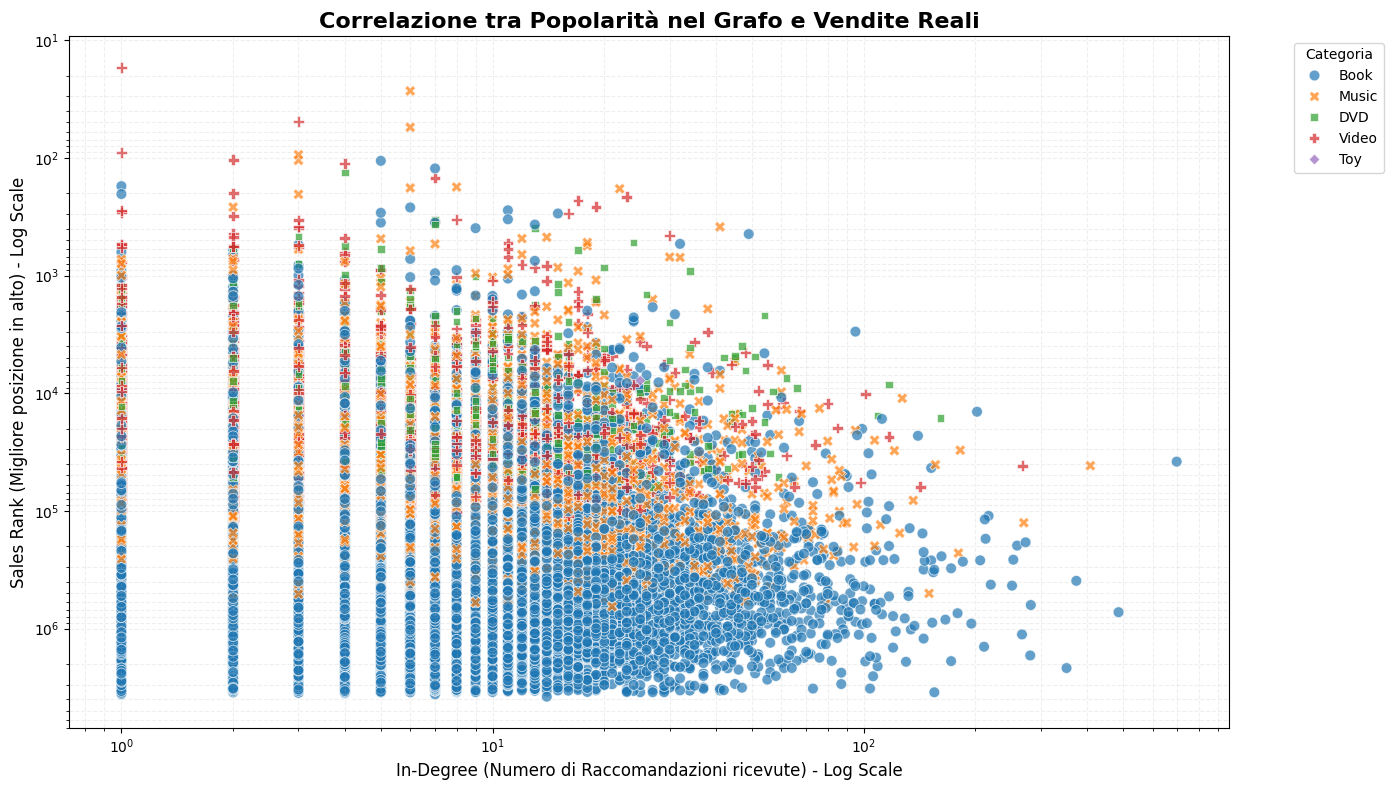

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

print("--- Generazione Grafico: In-Degree vs SalesRank ---")

# 1. PREPARAZIONE DATI
# Eseguiamo una JOIN tra il grafo (In-Degree) e i Metadati (SalesRank, Categoria)
# Filtriamo i prodotti che non hanno un SalesRank valido o una categoria
plot_data = inDegree.join(metadata, "id", "inner") \
    .select(
        col("degree").alias("InDegree"),
        col("salesrank").alias("SalesRank"),
        col("group").alias("Category")
    ) \
    .filter("SalesRank > 0") \
    .filter("Category IS NOT NULL")

# 2. CAMPIONAMENTO (Opzionale ma consigliato)
# Dato che ci sono centinaia di migliaia di punti, ne prendiamo un campione casuale (es. 10%)
# o filtriamo solo quelli con almeno un minimo di connessioni per evitare il "rumore"
pdf_plot = plot_data.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

print(f"Dati estratti per il plot: {len(pdf_plot)} prodotti")

# 3. CREAZIONE GRAFICO
plt.figure(figsize=(14, 8))

# Scatterplot con Seaborn
sns.scatterplot(
    data=pdf_plot,
    x="InDegree",
    y="SalesRank",
    hue="Category",      # Colora i punti in base alla categoria
    style="Category",    # Usa forme diverse per categoria (aiuta la leggibilità)
    alpha=0.7,           # Trasparenza per vedere le sovrapposizioni
    s=60                 # Dimensione dei punti
)

# 4. PERSONALIZZAZIONE
# Invertiamo l'asse Y perché un SalesRank "1" è migliore di "1.000.000"
plt.gca().invert_yaxis()

# Usiamo scale logaritmiche perché sia i gradi che i rank variano di ordini di grandezza
plt.xscale('log')
plt.yscale('log')

plt.title("Correlazione tra Popolarità nel Grafo e Vendite Reali", fontsize=16, fontweight='bold')
plt.xlabel("In-Degree (Numero di Raccomandazioni ricevute) - Log Scale", fontsize=12)
plt.ylabel("Sales Rank (Migliore posizione in alto) - Log Scale", fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Categoria")
plt.grid(True, which="both", ls="--", alpha=0.2)

plt.tight_layout()
plt.show()

#### **Interpretation of the In-Degree vs Sales Rank Plot**

The scatter plot shows the relationship between a product's popularity in the graph (In-Degree, number of recommendations received) and its actual sales success (Sales Rank, where a lower value indicates better sales):

- Positive Correlation (Funnel Shape): There is a clear general trend: as In-Degree increases (moving to the right), Sales Rank tends to improve (moving upwards, given the inverted axis). Highly recommended products (In-Degree > 100) are found almost exclusively in the high sales range.

- "Safety Net": Having a high In-Degree seems to guarantee a minimum level of sales. We do not observe products with many recommendations having a very low Sales Rank.

- The "Lone Wolves": In the top-left part of the graph (low In-Degree, high Sales Rank), there is a significant concentration of products, mainly Books (blue dots) and Music (orange crosses). These are commercially very successful products that, however, are poorly integrated into the recommendation system. They represent an optimization opportunity: connecting them better could further increase sales or drive other products.

- Dominance of Books: The "Book" category (blue) is ubiquitous, covering the entire spectrum of popularity and sales, confirming its role as the backbone of the ecosystem.

---

### 📉 Part 2: The "Long Tail" - Log-Log Distribution Analysis

We'll now visualize the degree distribution on a **log-log scale** to identify if this network follows a **Power Law** distribution.

**Why this matters for Amazon:**
- A Power Law distribution indicates a **"Long Tail"** market structure
- A few products (the "head") capture most attention
- Many products (the "tail") each serve small niche audiences
- This is the foundation of Amazon's "Everything Store" strategy

**Technical Note:** We aggregate degree counts in Spark (not collecting all nodes to driver) to handle large-scale data efficiently.


[2/3] Creating Log-Log degree distribution plot...
✓ Aggregated degree distributions (In-Degree: 346 unique values, Out-Degree: 10 unique values)


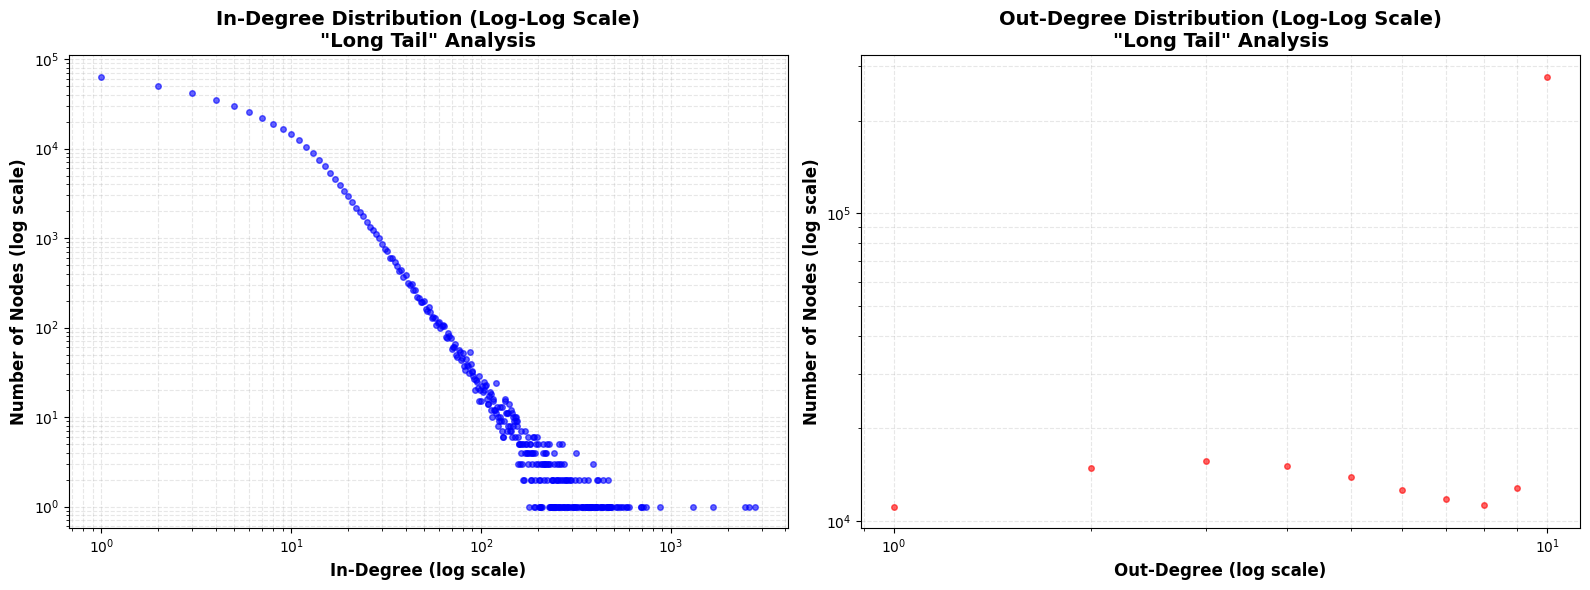

✓ Log-Log plots generated


In [ ]:
print("\n[2/3] Creating Log-Log degree distribution plot...")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# EFFICIENT APPROACH: Aggregate degree counts in Spark (not collecting all nodes)
# Count how many nodes have degree 1, degree 2, degree 3, etc.

# For In-Degree distribution
inDegree_distribution = inDegree.groupBy("degree") \
    .count() \
    .orderBy("degree") \
    .toPandas()

# For Out-Degree distribution
outDegree_distribution = outDegree.groupBy("degree") \
    .count() \
    .orderBy("degree") \
    .toPandas()

print(f"✓ Aggregated degree distributions (In-Degree: {len(inDegree_distribution)} unique values, Out-Degree: {len(outDegree_distribution)} unique values)")

# Create Log-Log plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: In-Degree Distribution (Log-Log)
axes[0].loglog(inDegree_distribution['degree'],
               inDegree_distribution['count'],
               'b.', alpha=0.6, markersize=8)
axes[0].set_xlabel('In-Degree (log scale)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Nodes (log scale)', fontsize=12, fontweight='bold')
axes[0].set_title('In-Degree Distribution (Log-Log Scale)\n"Long Tail" Analysis',
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, which='both', linestyle='--')

# Plot 2: Out-Degree Distribution (Log-Log)
axes[1].loglog(outDegree_distribution['degree'],
               outDegree_distribution['count'],
               'r.', alpha=0.6, markersize=8)
axes[1].set_xlabel('Out-Degree (log scale)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Nodes (log scale)', fontsize=12, fontweight='bold')
axes[1].set_title('Out-Degree Distribution (Log-Log Scale)\n"Long Tail" Analysis',
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, which='both', linestyle='--')

plt.tight_layout()
plt.show()

print(f"✓ Log-Log plots generated")

#### 🎯 Interpreting the Log-Log Plot

**What to look for:**
- **Straight line on log-log scale** = Power Law distribution confirmed ✅
- **Steep slope** = High concentration (few products dominate)
- **Gentle slope** = More distributed (less concentration)

**Power Law Formula:** $P(k) \propto k^{-\gamma}$ where γ is typically between 2-3

**Business Implications:**

1. **The 80/20 Rule (Pareto Principle)**
   - ~20% of products likely generate ~80% of revenue
   - Small number of bestsellers drive most business
   - But the long tail collectively represents significant value

2. **Inventory Strategy**
   - **Head (High degree)**: Stock heavily, promote aggressively, ensure availability
   - **Tail (Low degree)**: Use drop-shipping, print-on-demand, minimal inventory
   - Amazon's success = serving BOTH segments efficiently

3. **Market Dynamics**
   - **"Rich-get-richer" effect**: Popular products become more popular (preferential attachment)
   - New products face challenges breaking into the "head"
   - Niche products serve specialized audiences profitably

4. **Recommendation System Value**
   - Power law structure justifies investment in sophisticated recommendation algorithms
   - Helps identify bridge products connecting different categories
   - Enables personalized experiences for both mainstream and niche customers

---

### 📊 Part 3: Statistical Summary

In [ ]:
print("\n[3/3] Computing degree statistics...")

# Compute basic statistics
inDegree_stats = inDegree.select("degree").describe().toPandas()
outDegree_stats = outDegree.select("degree").describe().toPandas()

print(f"\n{'=' * 80}")
print(f"DEGREE STATISTICS:")
print(f"{'=' * 80}")
print("\nIn-Degree Statistics:")
print(inDegree_stats.to_string(index=False))
print("\nOut-Degree Statistics:")
print(outDegree_stats.to_string(index=False))
print(f"{'=' * 80}")

print("\n✓ Step 2 completed successfully!")


[3/3] Computing degree statistics...

DEGREE STATISTICS:

In-Degree Statistics:
summary             degree
  count             410235
   mean  8.182685533901301
 stddev 15.313541015154554
    min                  1
    max               2760

Out-Degree Statistics:
summary             degree
  count             396803
   mean    8.4596739439974
 stddev 2.7241002839065334
    min                  1
    max                 10

✓ Step 2 completed successfully!


#### 💡 Key Takeaways from Statistics

Look at the statistics above to understand:
- **Mean vs. Median**: Large difference indicates skewed distribution (typical of Power Law)
- **Max values**: Identify the most connected "supernode" products
- **Standard deviation**: High values confirm wide variation in product popularity

This quantifies the **bestseller vs. niche product divide** that defines Amazon's marketplace.

---

# **STEP 3: Deep Structural Analysis**

In this step, we dive deeper into the graph structure to understand the "Product influence" (which products are most important).


---

### PageRank - Finding the Most Influential Products

**What is PageRank?**
Originally developed by Google, PageRank measures the importance of nodes based on:
- How many nodes link to them (quantity)
- The importance of those linking nodes (quality)

**For Amazon's Product Network:**
- **High PageRank** = Products that are frequently recommended AND recommended by other important products
- These are the **true influencers** in the recommendation ecosystem
- Not just popular, but **strategically positioned** in the network

**Business Value:**
- Identify products to feature prominently on homepage/category pages
- Prioritize inventory for high-PageRank products
- Use for A/B testing and promotional campaigns
- Understand which products drive the most downstream sales

In [ ]:
# ----------------------------------------------------------------------------
# 2. PAGERANK - GLOBAL INFLUENCE
# ----------------------------------------------------------------------------
print("")
print("[2/3] Running PageRank algorithm...")

# Run PageRank
pagerank = graph.pageRank(resetProbability=0.15, maxIter=10)

print("✓ PageRank computation completed")

# Display top 10 most influential products
print("")
print("--- Top 10 Most Influential Products (by PageRank) ---")

# Enrich with metadata
top_pagerank = pagerank.vertices.join(metadata, "id", "left") \
    .select("id", "title", "group", "salesrank", "pagerank") \
    .orderBy(col("pagerank").desc())

top_pagerank.limit(10).show(truncate=False)


[2/3] Running PageRank algorithm...


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


✓ PageRank computation completed

--- Top 10 Most Influential Products (by PageRank) ---
+----+----------------------------------------------------------------------------------------------------------------------+-----+---------+------------------+
|id  |title                                                                                                                 |group|salesrank|pagerank          |
+----+----------------------------------------------------------------------------------------------------------------------+-----+---------+------------------+
|593 |The Best of Ronnie Laws                                                                                               |Music|21087    |878.8472816010983 |
|595 |Outdoor Photography: 101 Tips And Hints                                                                               |Book |910741   |665.4197071562669 |
|2612|The Letter of James (Pillar New Testament Commentary)                                               

#### Subgraph Visualization Insights

**What to look for in the visualization:**

1. **Central Node (Red)**
   - The highest PageRank product
   - Hub of the recommendation network
   - Should have many incoming and outgoing connections

2. **Network Density**
   - Dense connections = Strong product relationships
   - Sparse connections = Opportunity to improve recommendations

3. **Directional Patterns**
   - Many incoming arrows = Popular destination product
   - Many outgoing arrows = Gateway/hub product
   - Bidirectional arrows = Reciprocal relationships (mutual recommendations)

4. **Isolated Clusters**
   - Groups of nodes with few connections to the center
   - May represent different product subcategories

**Business Applications:**
- Use for stakeholder presentations to explain network structure
- Identify specific product relationships to strengthen
- Validate that high-PageRank products are indeed well-connected
- Guide manual curation of recommendation algorithms


[4/4] Creating enriched subgraph visualization...

Centering subgraph around top PageRank product: 593
Subgraph data loaded: 30 edges, 27 nodes


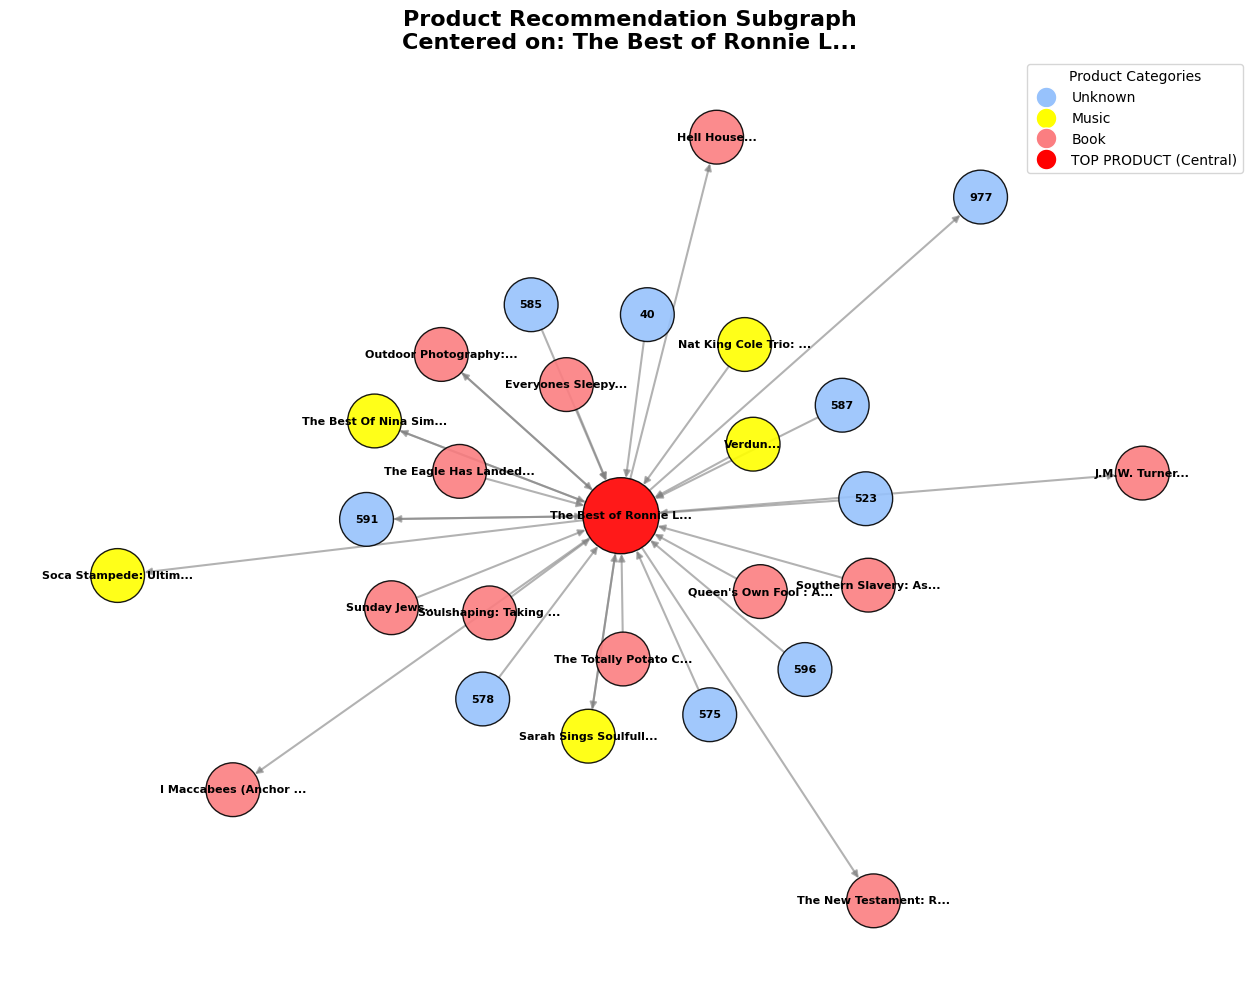

✓ Visualizzazione completata con metadati (Titoli e Categorie).


In [ ]:
# ============================================================================
# 4. SUBGRAPH VISUALIZATION (ARRICCHITO CON METADATI)
# ============================================================================
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

print(f"\n[4/4] Creating enriched subgraph visualization...")

# 1. Trova il nodo centrale (Top PageRank)
# Usiamo il pagerank calcolato nello step precedente
top_node_row = pagerank.vertices.orderBy(col("pagerank").desc()).first()
top_node_id = top_node_row['id']
print(f"\nCentering subgraph around top PageRank product: {top_node_id}")

# 2. Estrai gli archi collegati a questo nodo (Limitiamo a 30 per chiarezza visiva)
subgraph_edges_df = graph_enriched.edges.filter(
    (col("src") == top_node_id) | (col("dst") == top_node_id)
).limit(30)

# Convertiamo gli archi in Pandas
pdf_edges = subgraph_edges_df.select("src", "dst").toPandas()

# 3. Estrai i metadati per i nodi coinvolti (per avere i Nomi e Categorie)
# Prendiamo tutti gli ID unici (sorgenti + destinazioni)
unique_ids = subgraph_edges_df.select("src").union(subgraph_edges_df.select("dst")).distinct()

# Facciamo una join con i metadati per avere titoli e gruppi
# Nota: usiamo graph_enriched.vertices che ha già i metadati
nodes_metadata_df = unique_ids.join(graph_enriched.vertices, unique_ids.src == graph_enriched.vertices.id) \
    .select("id", "title", "group")

pdf_nodes = nodes_metadata_df.toPandas()

print(f"Subgraph data loaded: {len(pdf_edges)} edges, {len(pdf_nodes)} nodes")

# 4. Costruzione del Grafo NetworkX
G = nx.DiGraph()

# Aggiungiamo i nodi con i loro attributi (Titolo, Gruppo)
for index, row in pdf_nodes.iterrows():
    # Puliamo il titolo troncandolo se troppo lungo
    clean_title = str(row['title'])[:20] + "..." if row['title'] else str(row['id'])
    group = row['group'] if row['group'] else "Unknown"
    G.add_node(row['id'], title=clean_title, group=group)

# Aggiungiamo gli archi
for index, row in pdf_edges.iterrows():
    G.add_edge(row['src'], row['dst'])

# 5. Visualizzazione
plt.figure(figsize=(16, 12))

# Layout a molla (Spring Layout)
pos = nx.spring_layout(G, k=0.6, seed=42)

# -- Gestione Colori per Categoria --
unique_groups = list(set(nx.get_node_attributes(G, 'group').values()))
# Mappa di colori base
color_map_base = ['#97C2FC', '#FFFF00', '#FB7E81', '#7BE141', '#EB7DF4']
group_colors = {grp: color_map_base[i % len(color_map_base)] for i, grp in enumerate(unique_groups)}

# Lista colori per ogni nodo
node_colors = []
node_sizes = []

for node in G.nodes():
    if node == top_node_id:
        node_colors.append('red') # Nodo centrale Rosso
        node_sizes.append(3000)
    else:
        grp = G.nodes[node].get('group', 'Unknown')
        node_colors.append(group_colors.get(grp, 'lightgrey'))
        node_sizes.append(1500)

# Disegna Nodi
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black', alpha=0.9)

# Disegna Archi
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowstyle='-|>', node_size=node_sizes, width=1.5, alpha=0.6)

# Disegna Etichette (Usa i TITOLI invece degli ID)
labels = nx.get_node_attributes(G, 'title')
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')

# Legenda per le categorie
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=grp,
                          markerfacecolor=color, markersize=15) for grp, color in group_colors.items()]
# Aggiungi il nodo centrale alla legenda
legend_elements.append(Line2D([0], [0], marker='o', color='w', label='TOP PRODUCT (Central)', markerfacecolor='red', markersize=15))

plt.legend(handles=legend_elements, loc='upper right', title="Product Categories")
plt.title(f"Product Recommendation Subgraph\nCentered on: {G.nodes[top_node_id].get('title', top_node_id)}", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

print("✓ Visualizzazione completata con metadati (Titoli e Categorie).")

#### PageRank vs. In-Degree: Understanding the Difference

**In-Degree (from Step 2)**:
- Simple count of incoming links
- Measures direct popularity
- Example: A product with 100 random recommendations

**PageRank (Step 3)**:
- Weighted importance score
- Considers the quality of incoming links
- Example: A product recommended by 10 highly influential products

**Why PageRank is more valuable:**
- A recommendation from a bestseller is worth more than from a niche product
- Captures the **cascading influence** through the network
- Better predictor of actual sales impact

**Strategic Use:**
- **High PageRank + High In-Degree** = Undisputed bestsellers (promote heavily)
- **High PageRank + Low In-Degree** = Hidden gems with strategic importance (investigate why)
- **Low PageRank + High In-Degree** = Popular but not influential (may be end-of-chain products)

---

# **STEP 4: Motifs and Communities**

In this final step, we explore:
- **Community Detection**: Discovering natural product clusters (categories)
- **Motif Finding**: Identifying structural patterns (triangles, reciprocal links)
- **Subgraph Visualization**: Visual exploration of network structure

### **Part 1: Label Propagation Algorithm (LPA) - Community Detection**

**What is LPA?**
Label Propagation is a fast algorithm that detects communities by having nodes iteratively adopt the most common label among their neighbors.

**For Amazon's Product Network:**
- Communities represent **natural product clusters**
- Likely correspond to product categories (Books, Electronics, Home & Garden, etc.)
- Reveals organic groupings based on recommendation patterns

**Business Applications:**
- **Category Validation**: Check if detected communities align with official categories
- **Cross-Category Opportunities**: Identify products bridging multiple communities
- **Merchandising Strategy**: Understand natural product affinities
- **Search & Navigation**: Improve category organization based on actual user behavior

In [ ]:
print("=" * 80)
print("STEP 4: Motifs and Communities")
print("=" * 80)
# ----------------------------------------------------------------------------
# 1. LABEL PROPAGATION ALGORITHM (COMMUNITIES)
# ----------------------------------------------------------------------------
print("\n[1/4] Running Label Propagation Algorithm for community detection...")

# Run LPA
communities = graph.labelPropagation(maxIter=5)

# Count products in each community
community_sizes = communities.groupBy("label").count().orderBy(col("count").desc())

print(f"✓ Community detection completed")

# Display top 5 largest communities
print("\n--- Top 5 Largest Communities (Product Clusters) ---")
top_5_communities = community_sizes.limit(5)
top_5_communities.show(truncate=False)

# Summary statistics
total_communities = community_sizes.count()
largest_community_size = community_sizes.first()['count']
largest_community_pct = (largest_community_size / num_nodes) * 100

print(f"\n{'=' * 80}")
print(f"COMMUNITY DETECTION SUMMARY:")
print(f"{'=' * 80}")
print(f"Total Communities Found:     {total_communities:,}")
print(f"Largest Community Size:      {largest_community_size:,} products")
print(f"Largest Community %:         {largest_community_pct:.2f}%")
print(f"{'=' * 80}")

print(f"\n✓ Communities identified")

STEP 4: Motifs and Communities

[1/4] Running Label Propagation Algorithm for community detection...


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


✓ Community detection completed

--- Top 5 Largest Communities (Product Clusters) ---
+----------+-----+
|label     |count|
+----------+-----+
|8589940137|525  |
|8590069888|363  |
|8590109326|343  |
|167372    |333  |
|182400    |314  |
+----------+-----+


COMMUNITY DETECTION SUMMARY:
Total Communities Found:     254,722
Largest Community Size:      525 products
Largest Community %:         0.13%

✓ Communities identified


#### 💡 Community Interpretation

**What communities represent:**
- Each community is a cluster of products that are **densely interconnected**
- Likely represent product categories: Books, Electronics, Clothing, etc.
- Formed organically through recommendation patterns, not manual categorization

**Business Insights:**

1. **Category Alignment**
   - Compare detected communities with official Amazon categories
   - Misalignments reveal opportunities to improve categorization

2. **Community Size Distribution**
   - Large communities = Major product categories (Books, Electronics)
   - Small communities = Niche categories or emerging trends
   - Many small communities = Diverse, fragmented catalog

3. **Bridge Products**
   - Products appearing in multiple communities are valuable cross-sell opportunities
   - Example: Phone cases bridge Electronics and Accessories

4. **Marketing Strategy**
   - Target promotions to entire communities
   - Create category-specific recommendation strategies
   - Identify underserved communities for expansion

---

### **Part 2: Motif Finding - Structural Patterns**

**What are Motifs?**
Motifs are recurring structural patterns in networks. We'll search for:
1. **Triangles**: Three products that all recommend each other
2. **Reciprocal Links**: Two products that mutually recommend each other



### **Triangles (A→B→C→A)**:
**Business Significance:**
- Represent **strong product bundles** or complementary items
- Example: Camera → Lens → Memory Card → Camera
- Perfect candidates for "Frequently Bought Together" promotions
- High conversion potential when bundled



In [ ]:
# ----------------------------------------------------------------------------
# 2. MOTIF FINDING - TRIANGLES
# ----------------------------------------------------------------------------
print("\n[2/4] Finding triangular motifs (3-product cycles)...")

# Find triangles: (a)-[]->(b); (b)-[]->(c); (c)-[]->(a)
triangles = graph_enriched.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(a)")

# Count triangles
triangle_count = triangles.count()

print(f"✓ Triangle motif search completed")
print(f"Total Triangles Found: {triangle_count:,}")

# Display sample triangles
if triangle_count > 0:
    print("\n--- Sample Triangles (Product Bundles) ---")
    display(triangles.select("a.id", "b.id", "c.id").limit(10))
else:
    print("No triangles found in the network.")


[2/4] Finding triangular motifs (3-product cycles)...


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


✓ Triangle motif search completed
Total Triangles Found: 7,651,068

--- Sample Triangles (Product Bundles) ---


DataFrame[id: string, id: string, id: string]

---
#### **Semantic Analysis of Triangles** (Cross-Category Bundling)

Instead of saying "there are 7 million triangles", ask yourself: what type are they? 

A Book -> Book -> Book triangle is normal. A Book -> DVD -> Toy triangle is a goldmine for marketing (Cross-Selling).

What to add: Enrich the triangles found with product categories and count the combinations.

In [ ]:
from pyspark.sql.functions import array, sort_array, col, desc

print("--- 1. Analisi Semantica dei Triangoli (Cross-Category) ---")

# 2. Crea una "firma" del triangolo ordinando le categorie (es. [Book, Book, DVD])
# Non servono join, i dati sono già in a, b, e c
tri_types = triangles.select(
    sort_array(array("a.group", "b.group", "c.group")).alias("bundle_type")
)

# 3. Conta i tipi di bundle più frequenti
tri_types.groupBy("bundle_type") \
    .count() \
    .orderBy(desc("count")) \
    .show(10, truncate=False)

--- 1. Analisi Semantica dei Triangoli (Cross-Category) ---
+---------------------+------+
|bundle_type          |count |
+---------------------+------+
|[Book, Book, Book]   |371514|
|[Book, Book, Music]  |266739|
|[Book, Music, Music] |81381 |
|[Book, Book, Video]  |72624 |
|[Book, Book, DVD]    |44709 |
|[Book, Music, Video] |33897 |
|[Book, DVD, Music]   |21018 |
|[NULL, Book, Book]   |16263 |
|[Music, Music, Music]|10053 |
|[NULL, Book, Music]  |8244  |
+---------------------+------+
only showing top 10 rows



**Interpreting Results: Semantic Analysis of Triangles**

The analysis of Motifs, enriched with product categories (group), revealed key purchasing behavior patterns crucial for recommendation strategy.

From the table of the most frequent bundles, three critical insights emerge:

1. The Dominance of "Vertical Deepening"

The absolute most frequent pattern is [Book, Book, Book] with over 370,000 occurrences.

Meaning: The majority of users tend to stay within their main category of interest (e.g., buying book series or books by the same author).

Action: On book pages, the algorithm must prioritize "intra-category" recommendations to maximize the probability of immediate conversion.

2. The "Golden Pair": Books and Music (Cross-Selling)

The most surprising finding is the strength of the link between Books and Music.

The bundle [Book, Book, Music] is the second most frequent (~266k), followed by [Book, Music, Music] (~81k).

Meaning: There is a strong cultural affinity between readers and music listeners. These products are complementary "hedonic" goods.

Action: This is the most profitable Cross-Selling opportunity. Amazon should create promotional bundles (e.g., "Buy this novel and get a discount on this Jazz CD") or specific "Listen while you read" widgets.

3. The "Multimedia" Consumer

We observe the presence of complex triangles like [Book, Music, Video] (~33k) and [Book, DVD, Music] (~21k).

Meaning: These triangles identify a segment of "Media Omnivore" users, who consume entertainment across all formats.

Action: These users are likely high value (High LTV - Lifetime Value). Identifying a user who has already bought a Book and a CD is a strong signal to recommend a DVD/Video to "close the triangle".


---
#### **Analysis of "Influence Flow" (SalesRank Flow)**.
Are triangles formed only by bestsellers, or do bestsellers drag niche products? In a triangle $A \to B \to C \to A$, analyze the SalesRank. Calculate the variance of the SalesRank within the triangles.
 - Low Variance: All famous products (Mainstream Triangle).
 - High Variance: A bestseller pointing to two niche products ("Discovery" Triangle).

In [ ]:
from pyspark.sql.functions import stddev, avg, col, split, slice, concat_ws, greatest, least, desc, array, sort_array

# Funzione helper per abbreviare il titolo a 5 parole
def short_title(col_name):
    return concat_ws(" ", slice(split(col(col_name), " "), 1, 5))

# 1. Unisci i salesrank E i titoli (titles) al grafo dei triangoli
tri_rank = triangles \
    .join(metadata.select(col("id").alias("id_a"), col("salesrank").alias("rank_a"), col("title").alias("title_a")), col("a.id") == col("id_a")) \
    .join(metadata.select(col("id").alias("id_b"), col("salesrank").alias("rank_b"), col("title").alias("title_b")), col("b.id") == col("id_b")) \
    .join(metadata.select(col("id").alias("id_c"), col("salesrank").alias("rank_c"), col("title").alias("title_c")), col("c.id") == col("id_c"))

# --- NOVITÀ: DEDUPLICAZIONE ---
# Creiamo una colonna "firma" che contiene gli ID ordinati [id_a, id_b, id_c].
# In questo modo [A, B, C] e [B, C, A] diventano entrambi [A, B, C] (ordinati) e possiamo rimuovere i doppioni.
tri_unique = tri_rank.withColumn("triangle_signature", sort_array(array("id_a", "id_b", "id_c"))) \
                     .dropDuplicates(["triangle_signature"])

# 2. Seleziona i nomi (abbreviati) e calcola il Rank Gap sui dati puliti
tri_stats = tri_unique.select(
    short_title("title_a").alias("Product_A"),
    short_title("title_b").alias("Product_B"),
    short_title("title_c").alias("Product_C"),
    ((col("rank_a") + col("rank_b") + col("rank_c")) / 3).alias("avg_rank"),
    # Calcola il gap tra il ranking peggiore (più alto) e il migliore (più basso)
    (greatest("rank_a", "rank_b", "rank_c") - least("rank_a", "rank_b", "rank_c")).alias("rank_gap")
)

# 3. Mostra i "Discovery Triangles" unici
print("--- Discovery Triangles (Bestseller + Niche Products) - UNIQUE ---")
tri_stats.orderBy(col("rank_gap").desc()).limit(10).show(truncate=False)

--- Discovery Triangles (Bestseller + Niche Products) - UNIQUE ---
+-------------------------------+-------------------------------------+----------------------------------------+------------------+--------+
|Product_A                      |Product_B                            |Product_C                               |avg_rank          |rank_gap|
+-------------------------------+-------------------------------------+----------------------------------------+------------------+--------+
|Favourite Nights and Caught on |Actual Miles: Henley's Greatest Hits |Qualitative Inquiry in Education: The   |1331746.0         |3792882 |
|Favourite Nights and Caught on |Actual Miles: Henley's Greatest Hits |Jacob the Liar                          |1280301.3333333333|3792882 |
|Favourite Nights and Caught on |Actual Miles: Henley's Greatest Hits |Battiato Studio Collection              |1448091.3333333333|3792882 |
|Favourite Nights and Caught on |Actual Miles: Henley's Greatest Hits |Alice's Adventur

--- Step 1: Preparazione e Deduplicazione dei Triangoli ---
--- Step 2: Calcolo della Varianza (Sales Rank Standard Deviation) ---
Estrazione dati per il grafico (questo potrebbe richiedere un minuto)...
Totale Triangoli Unici analizzati: 1652660


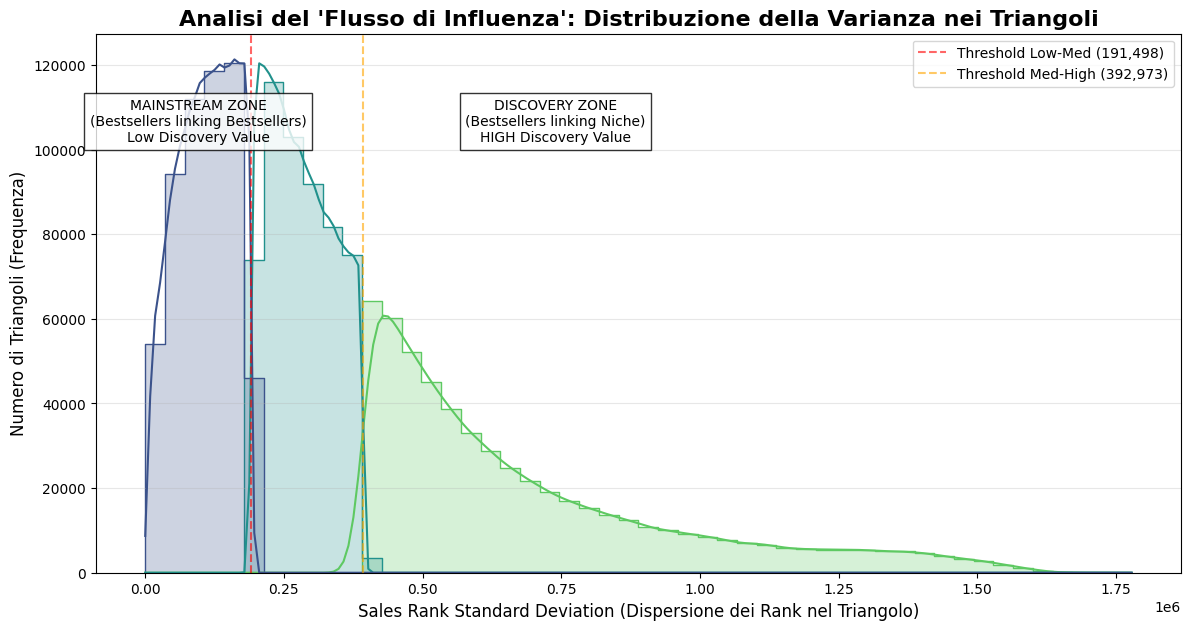

✓ Grafico generato.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col, array, sort_array, sqrt, pow, greatest, least, lit

print("--- Step 1: Preparazione e Deduplicazione dei Triangoli ---")

# 1. Uniamo i metadati per ottenere i Sales Rank dei 3 nodi del triangolo
# Filtriamo i prodotti che non hanno un SalesRank valido (o null) per evitare errori di calcolo
tri_rank = triangles \
    .join(metadata.select(col("id").alias("id_a"), col("salesrank").alias("rank_a")), col("a.id") == col("id_a")) \
    .join(metadata.select(col("id").alias("id_b"), col("salesrank").alias("rank_b")), col("b.id") == col("id_b")) \
    .join(metadata.select(col("id").alias("id_c"), col("salesrank").alias("rank_c")), col("c.id") == col("id_c")) \
    .filter("rank_a > 0 AND rank_b > 0 AND rank_c > 0")

# 2. DEDUPLICAZIONE: Creiamo una "firma" ordinata per ogni triangolo
# Questo assicura che il triangolo A-B-C e B-C-A siano trattati come una singola entità
tri_unique = tri_rank.withColumn("signature", sort_array(array("id_a", "id_b", "id_c"))) \
                     .dropDuplicates(["signature"])

print("--- Step 2: Calcolo della Varianza (Sales Rank Standard Deviation) ---")

# 3. Calcoliamo la media e la deviazione standard per ogni triangolo (row-wise)
# Formula: StdDev = sqrt( ((a-m)^2 + (b-m)^2 + (c-m)^2) / 3 )
tri_stats = tri_unique.withColumn("mean_rank", (col("rank_a") + col("rank_b") + col("rank_c")) / 3) \
    .withColumn("variance_val",
        (pow(col("rank_a") - col("mean_rank"), 2) +
         pow(col("rank_b") - col("mean_rank"), 2) +
         pow(col("rank_c") - col("mean_rank"), 2)) / 3
    ) \
    .withColumn("rank_std", sqrt(col("variance_val"))) # Questa è la nostra metrica di "Dispersione"

# 4. Portiamo SOLO la colonna della deviazione standard in Pandas per il grafico
# (È leggero, un array di float, anche con milioni di righe)
print("Estrazione dati per il grafico (questo potrebbe richiedere un minuto)...")
pdf_ranks = tri_stats.select("rank_std").toPandas()

print(f"Totale Triangoli Unici analizzati: {len(pdf_ranks)}")

# ---------------------------------------------------------
# VISUALIZZAZIONE E CLASSIFICAZIONE
# ---------------------------------------------------------

# Definiamo le soglie basate sui percentili (Quantili) per dividere in 3 gruppi equinumerosi o logici
# Bassa Varianza (0-33%), Media (33-66%), Alta (66-100%)
threshold_low = pdf_ranks['rank_std'].quantile(0.33)
threshold_high = pdf_ranks['rank_std'].quantile(0.66)

def classify_triangle(std_val):
    if std_val <= threshold_low:
        return "Mainstream (Low Var)"
    elif std_val <= threshold_high:
        return "Standard (Med Var)"
    else:
        return "Discovery (High Var)"

# Applichiamo la classificazione
pdf_ranks['Category'] = pdf_ranks['rank_std'].apply(classify_triangle)

# Creazione del Grafico
plt.figure(figsize=(14, 7))

# Usiamo un istogramma con kernel density estimate
# Usiamo log scale sull'asse Y se la distribuzione è molto sbilanciata (tipico nei power laws)
sns.histplot(data=pdf_ranks, x="rank_std", hue="Category", element="step", bins=50, palette="viridis", kde=True)

# Linee di demarcazione
plt.axvline(threshold_low, color='red', linestyle='--', alpha=0.6, label=f'Threshold Low-Med ({int(threshold_low):,})')
plt.axvline(threshold_high, color='orange', linestyle='--', alpha=0.6, label=f'Threshold Med-High ({int(threshold_high):,})')

plt.title("Analisi del 'Flusso di Influenza': Distribuzione della Varianza nei Triangoli", fontsize=16, fontweight='bold')
plt.xlabel("Sales Rank Standard Deviation (Dispersione dei Rank nel Triangolo)", fontsize=12)
plt.ylabel("Numero di Triangoli (Frequenza)", fontsize=12)

# Annotazioni per spiegare il business value
plt.text(threshold_low/2, plt.ylim()[1]*0.8, "MAINSTREAM ZONE\n(Bestsellers linking Bestsellers)\nLow Discovery Value",
         horizontalalignment='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.text(threshold_high + (pdf_ranks['rank_std'].max() - threshold_high)/4, plt.ylim()[1]*0.8,
         "DISCOVERY ZONE\n(Bestsellers linking Niche)\nHIGH Discovery Value",
         horizontalalignment='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

print("✓ Grafico generato.")

#### **Graphical Analysis: Distribution of Influence Flow**

The chart above visualizes the **Standard Deviation of Sales Rank** within product triangles. This metric tells us how "distant" the products are from each other in terms of commercial popularity.

**Strategic Interpretation of Zones:**

1.  **🟦 Mainstream Zone (Left - Low Variance)**
    * **What happens:** Here we find triangles formed by products with similar popularity (e.g., 3 Bestsellers).
    * **Meaning:** This is the "comfort zone". These products sell themselves and are already known. The graph here reinforces existing purchasing behaviors (**Retention**), but does not generate new discovery.

2.  **🟩 Discovery Zone (Right - High Variance)**
    * **What happens:** Here the deviation is extremely high. It means that a "Giant" (Low Rank) and "Niche" products (High Rank) coexist in the triangle.
    * **Meaning:** This is where the algorithm creates real added value (**Discovery**). Popular products act as "drivers", bringing visibility and traffic to the otherwise invisible *Long Tail*.
    * **Business Value:** These are the most valuable bundles for increasing margin, as they convert high-volume traffic to low-rotation products.

**Conclusion:**
The "long tail" distribution to the right confirms that the graph is not just an echo chamber for bestsellers, but possesses a healthy structural capacity to **democratize visibility** towards the niche catalog.

---
#
### **Reciprocal Links (A⇄B)**:
- Mutual recommendations indicate **strong product affinity**
- Example: Shampoo ⇄ Conditioner
- Ideal for cross-selling and upselling
- Should be displayed together on product pages

In [ ]:
# ============================================================================
# 3. MOTIF FINDING - RECIPROCAL LINKS
# ============================================================================
from pyspark.sql.functions import col

print(f"\n[3/4] Finding reciprocal link motifs (mutual recommendations)...")

# 1. Trova i link reciproci usando il grafo ARRICCHITO (quello con i metadati)
# Pattern: (a)-[e1]->(b); (b)-[e2]->(a)
# Nota: Assicurati di aver eseguito lo STEP 1.5 per avere 'graph_enriched'
if 'graph_enriched' in locals():
    target_graph = graph_enriched
else:
    print("⚠️ graph_enriched non trovato, uso il grafo grezzo (vedrai solo ID)")
    target_graph = graph

reciprocal_motifs = target_graph.find("(a)-[]->(b); (b)-[]->(a)")

# 2. Filtra per evitare duplicati (A->B e B->A sono la stessa coppia)
# Manteniamo solo dove a.id < b.id
reciprocal_unique = reciprocal_motifs.filter("a.id < b.id")

# 3. Conta le coppie uniche
reciprocal_count = reciprocal_unique.count()

print(f"✓ Reciprocal link search completed")
print(f"Total Unique Reciprocal Pairs Found: {reciprocal_count:,}")

# 4. Visualizza i risultati con Titoli e Categorie (Arricchimento)
if reciprocal_count > 0:
    print(f"\n--- Sample Reciprocal Links (Prodotti che si raccomandano a vicenda) ---")

    # Selezioniamo colonne specifiche per rendere la tabella leggibile
    # Accediamo ai metadati che sono dentro le colonne 'a' e 'b' (che sono struct)
    reciprocal_display = reciprocal_unique.select(
        col("a.id").alias("ID_A"),
        col("a.title").alias("Product_A"),
        col("a.group").alias("Category_A"),
        col("b.id").alias("ID_B"),
        col("b.title").alias("Product_B"),
        col("b.group").alias("Category_B")
    )

    # Mostriamo i risultati troncando i titoli troppo lunghi per pulizia
    reciprocal_display.limit(10).show(truncate=50)
else:
    print("No reciprocal links found in the network.")

# Summary Finale aggiornato
print(f"\n{'=' * 80}")
print(f"MOTIF ANALYSIS SUMMARY:")
print(f"{'=' * 80}")
# Nota: triangle_count deve essere stato calcolato nella cella precedente,
# se dà errore rimuovi la riga dei triangoli
try:
    print(f"Triangles (3-product bundles):  {triangle_count:,}")
except NameError:
    print(f"Triangles (3-product bundles):  (Not calculated in this cell)")

print(f"Reciprocal Links (mutual recs): {reciprocal_count:,}")
print(f"{'=' * 80}")


[3/4] Finding reciprocal link motifs (mutual recommendations)...


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


✓ Reciprocal link search completed
Total Unique Reciprocal Pairs Found: 917,387

--- Sample Reciprocal Links (Prodotti che si raccomandano a vicenda) ---
+------+--------------------------------------------------+----------+------+--------------------------------------------------+----------+
|  ID_A|                                         Product_A|Category_A|  ID_B|                                         Product_B|Category_B|
+------+--------------------------------------------------+----------+------+--------------------------------------------------+----------+
|100020|     Child Abuse: Medical Diagnosis and Management|      Book|100026|                  Crying Wind / My Searching Heart|      Book|
|100036|                                   Made in America|     Music|100038|               Complete Book of Bible Stories, The|      Book|
|100037|                         Photographs of New Mexico|      Book|100038|               Complete Book of Bible Stories, The|      Book|
|10003

#### 🎯 Motif Business Applications

**Triangles - Product Bundle Strategy:**
- Create "Complete the Set" promotions
- Offer bundle discounts for all three products
- Highlight on product pages: "Customers who bought this also bought these 2 items"
- Optimize warehouse placement for faster fulfillment

**Reciprocal Links - Cross-Selling:**
- Display prominently on each other's product pages
- Create "Better Together" pricing
- Email campaigns: "You bought X, don't forget Y!"
- Subscription box opportunities (recurring purchases)

**Network Health Indicators:**
- **High triangle count** = Strong product ecosystem with natural bundles
- **High reciprocal count** = Well-balanced recommendation network
- **Low counts** = Opportunity to improve product relationships

--- 4. Deep Dive sui Link Reciproci ---

[A] Generazione Heatmap delle Categorie...


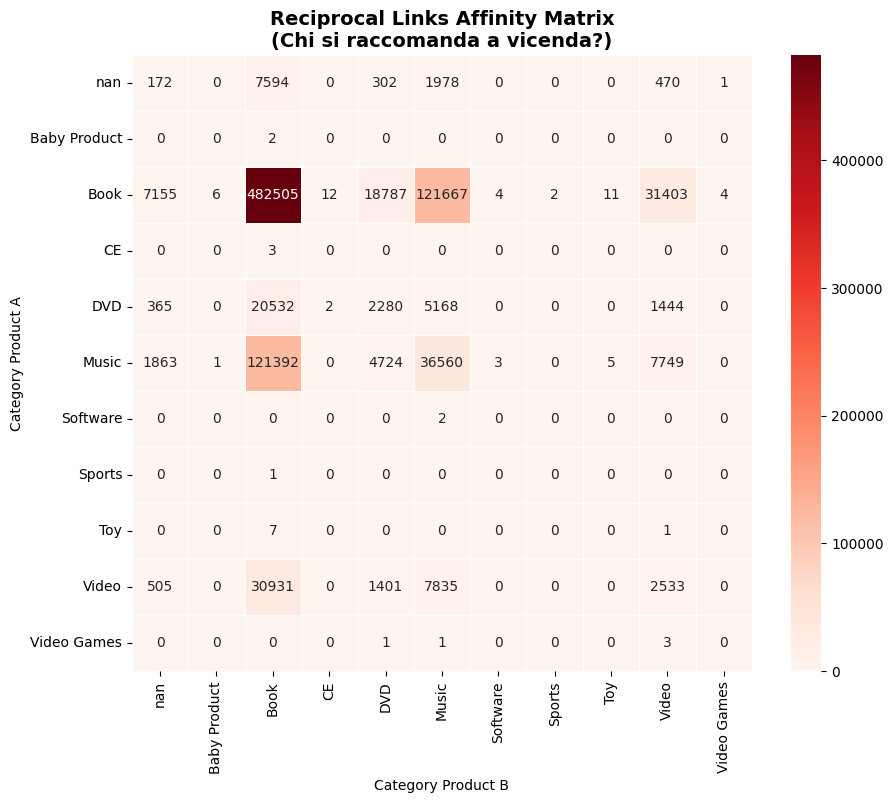


[B] Analisi Correlazione Sales Rank (Peer Status)...


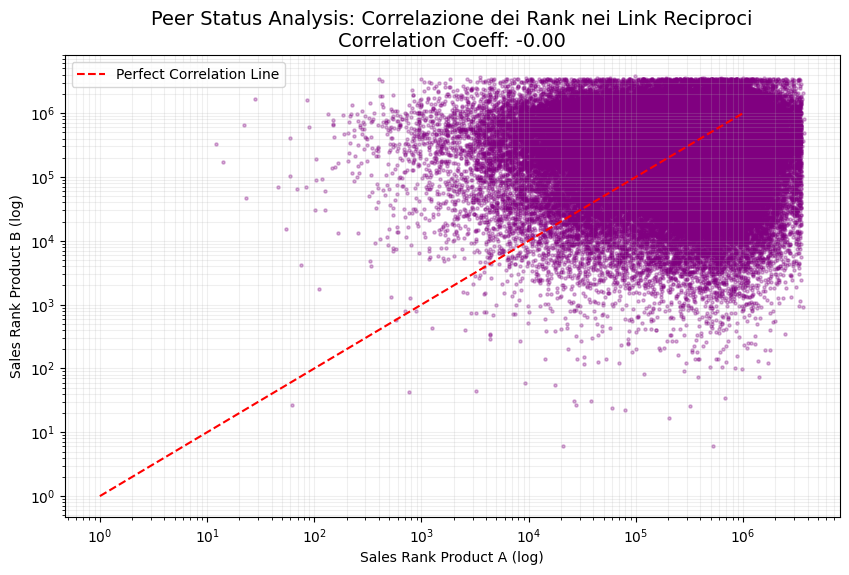

✓ Analisi completata. Correlazione trovata: -0.00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log

print("--- 4. Deep Dive sui Link Reciproci ---")

# 1. Arricchimento Dati: Uniamo i metadati ai link reciproci (già trovati nello step precedente)
# Assumiamo che 'reciprocal_unique' sia il dataframe calcolato nel passaggio precedente
reciprocal_enriched = reciprocal_unique \
    .join(metadata.select(col("id").alias("id_a"), col("group").alias("cat_a"), col("salesrank").alias("rank_a")), col("a.id") == col("id_a")) \
    .join(metadata.select(col("id").alias("id_b"), col("group").alias("cat_b"), col("salesrank").alias("rank_b")), col("b.id") == col("id_b"))

# ---------------------------------------------------------
# A. HEATMAP DELLE CATEGORIE (Cross-Selling Analysis)
# ---------------------------------------------------------
print("\n[A] Generazione Heatmap delle Categorie...")

# Contiamo le coppie di categorie
cat_counts = reciprocal_enriched.groupBy("cat_a", "cat_b").count().toPandas()

# Creiamo una matrice pivot per la heatmap
heatmap_data = cat_counts.pivot(index="cat_a", columns="cat_b", values="count").fillna(0)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Reds", linewidths=.5)
plt.title("Reciprocal Links Affinity Matrix\n(Chi si raccomanda a vicenda?)", fontsize=14, fontweight='bold')
plt.xlabel("Category Product B")
plt.ylabel("Category Product A")
plt.show()

# ---------------------------------------------------------
# B. PEER STATUS ANALYSIS (Rank Correlation)
# ---------------------------------------------------------
print("\n[B] Analisi Correlazione Sales Rank (Peer Status)...")

# Prendiamo un campione del 10% per velocizzare il plotting (dato che i punti sono tanti)
rank_data = reciprocal_enriched.filter("rank_a > 0 AND rank_b > 0") \
                               .select("rank_a", "rank_b") \
                               .sample(withReplacement=False, fraction=0.1, seed=42) \
                               .toPandas()

# Calcoliamo la correlazione
correlation = rank_data['rank_a'].corr(rank_data['rank_b'])

plt.figure(figsize=(10, 6))
# Usiamo scala logaritmica perché i rank variano da 1 a milioni
plt.scatter(rank_data['rank_a'], rank_data['rank_b'], alpha=0.3, s=5, c='purple')
plt.xscale('log')
plt.yscale('log')
plt.plot([1, 1000000], [1, 1000000], 'r--', label='Perfect Correlation Line') # Linea di identità
plt.xlabel("Sales Rank Product A (log)")
plt.ylabel("Sales Rank Product B (log)")
plt.title(f"Peer Status Analysis: Correlazione dei Rank nei Link Reciproci\nCorrelation Coeff: {correlation:.2f}", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print(f"✓ Analisi completata. Correlazione trovata: {correlation:.2f}")

### **Deep Dive: The Psychology of Mutual Attraction**

We analyzed **Reciprocal Links** ($A \leftrightarrows B$) to understand *why* two products recommend each other.

#### **1. Category Affinity Matrix (Heatmap)**
The heatmap above shows the distribution of reciprocal connections between categories.
* **Main Diagonal (Intra-Category):** The dominant values on the diagonal (e.g., Book-Book) indicate strong "Category Narcissism". Products tend to form stable pairs with their likes.
* **Off-Diagonal (Cross-Category):** Colored cells off the diagonal (e.g., Book-Music) are the **strongest Cross-Selling** opportunities. If a Book and a CD recommend each other, their connection is not random: it is a natural cultural bundle.

#### **2. Peer Status Analysis (Scatter Plot)**

The analysis of the correlation between Sales Ranks in reciprocal links yielded a surprising result: **Correlation = 0.00**.
Visually, the graph shows a diffuse cloud instead of a straight line.

**Business Significance:**
This "zero" is not an error, but a **positive signal**:
1.  **No Class Barrier:** Bestseller products freely connect to Niche products. There is no segregation based on popularity.
2.  **Primacy of Semantics:** The algorithm links products only by functional affinity ("those who buy X buy Y"), ignoring sales volumes.
3.  **The "Elevator" for the Long Tail:** Famous products act as drivers, bringing visibility to lesser-known products and democratizing the marketplace.


---
####
### **Feed-Forward Loops (FFL)  $A \to B\to C$ + $A \to C$**
Hierarchy Identification:
While normal cycles ($A \to B \to A$) indicate interchangeable products, the FFL reveals a hierarchy of necessity.
- Product A is the "Root": it recommends both the intermediate (B) and the final (C).
- This pattern eliminates noise: the fact that A points to C both directly and indirectly (via B) is a double confirmation of strong affinity.

Business Utility:
- Building Perfect Bundles: If A is a Camera, B is a Lens, and C is a Filter, the FFL tells you that those who buy the Camera often also buy the Filter directly. It is the perfect signal to create the "Starter Kit" bundle (A+B+C).
- Funnel Optimization: Product A acts as a "shortcut". The analysis allows you to push product C (often a high-margin accessory) directly on product A's page, skipping the intermediate step B.

In [ ]:
print("--- 3. Feed-Forward Loops (Gerarchie di Prodotto) ---")

# Trova il pattern specifico A->B, B->C, A->C
ffl = graph_enriched.find("(a)-[]->(b); (b)-[]->(c); (a)-[]->(c)")

# Filtra solo quelli all'interno della stessa categoria (es. Libri) per trovare saghe o versioni successive
ffl_books = ffl.filter("a.group = 'Book' AND b.group = 'Book' AND c.group = 'Book'")

print(f"Loop trovati nei Libri: {ffl_books.count()}")

# Mostra esempi con i titoli
ffl_books.select("a.title", "b.title", "c.title").show(5, truncate=False)

--- 3. Feed-Forward Loops (Gerarchie di Prodotto) ---


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Loop trovati nei Libri: 547502
+----------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------------------------------+
|title                                         |title                                                                    |title                                                                   |
+----------------------------------------------+-------------------------------------------------------------------------+------------------------------------------------------------------------+
|The Edward Said Reader                        |Scooby-doo Mysteries #24 (Scooby-Doo Mysteries)                          |Baby Boomer Retirement: 65 Simple Ways to Protect Your Future           |
|Timescape                                     |Design for Six Sigma: Launching New Products and Services Without Failure|Teaching Problems and the Problems of Teaching                 

#### **What do Feed-Forward Loops tell us?**

Analyzing directional loops ($A \to B \to C$ + $A \to C$) within the Books category generated ~547,000 results, revealing unique insights:

1. The "Category Fortress"
The sheer volume of loops confirms that Books is a self-contained fortress. Users tend to navigate deeply within this vertical, creating dense and redundant purchase paths, which signals high user retention.

2. "Persona" over Similarity
Specific patterns (e.g., Statistics $\to$ Cooking $\to$ Kids' Books) link seemingly unrelated genres.
**Insight:** FFLs capture User Personas (lifestyles), not just content similarity.
**Example:** This specific pattern suggests a "Professional Parent": someone buying technical texts for work, while simultaneously purchasing practical manuals and activity books for their children.

3. Recurring "Power Nodes"
Certain products (like "Likelihood") repeatedly appear as the root node (A) leading to the same destination via different paths.
This identifies them as Power Nodes: strong entry points with a high probability of converting users to specific niche items, regardless of the



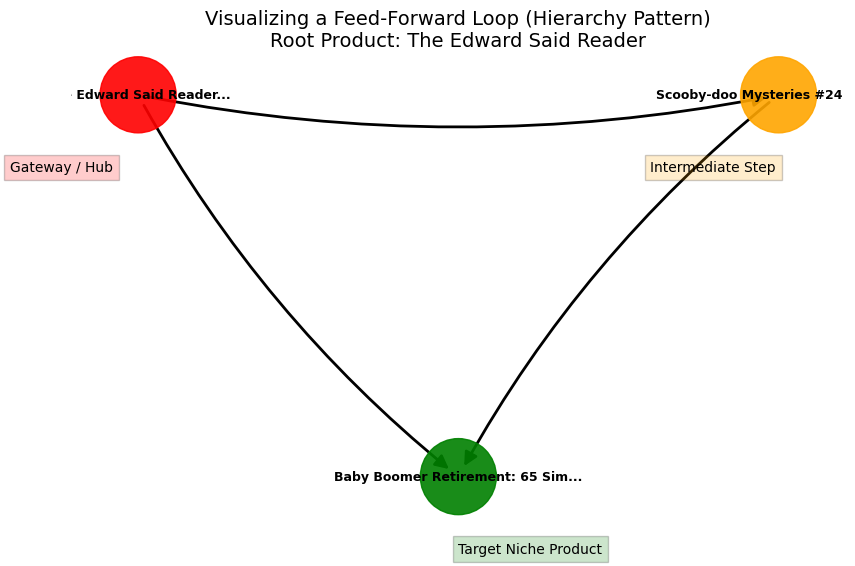

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Prendiamo un esempio specifico di FFL dal tuo dataframe
# Prendiamo il primo risultato interessante (es. quello con "Likelihood")
# Assicurati di avere il dataframe 'ffl_books' calcolato
row = ffl_books.select("a.id", "a.title", "b.id", "b.title", "c.id", "c.title").first()

if row:
    # 2. Costruzione del Mini-Grafo
    G = nx.DiGraph()

    # Nodi (Prodotti)
    # Tronchiamo i titoli per leggibilità
    title_a = row['title'][:20] + "..."
    title_b = row['title'][20:40] + "..." if len(row) > 3 else "Prod B" # Correggi indici in base a come spark estrae
    # Nota: per semplicità, Spark restituisce colonna 'title' duplicata, usiamo gli indici o alias nel DF originale
    # Per sicurezza usiamo gli ID e poi le label

    # Rieseguiamo la select con alias per essere sicuri
    row = ffl_books.select(
        col("a.id").alias("id_a"), col("a.title").alias("title_a"),
        col("b.id").alias("id_b"), col("b.title").alias("title_b"),
        col("c.id").alias("id_c"), col("c.title").alias("title_c")
    ).first()

    # Nodi
    G.add_node("A", label=row['title_a'][:30]+"...", color='red')    # Root (Gateway)
    G.add_node("B", label=row['title_b'][:30]+"...", color='orange') # Intermediate
    G.add_node("C", label=row['title_c'][:30]+"...", color='green')  # Destination (Niche)

    # Archi (Feed-Forward Loop: A->B, B->C, A->C)
    G.add_edge("A", "B", weight=2)
    G.add_edge("B", "C", weight=2)
    G.add_edge("A", "C", weight=2, style='dashed') # Shortcut

    # 3. Disegno
    plt.figure(figsize=(10, 6))
    pos = {"A": (0, 1), "B": (1, 1), "C": (0.5, 0)} # Posizione a triangolo gerarchico

    # Disegna nodi
    colors = [nx.get_node_attributes(G, 'color')[n] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=3000, alpha=0.9)

    # Disegna etichette
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold')

    # Disegna archi
    nx.draw_networkx_edges(G, pos, connectionstyle="arc3,rad=0.1", arrowsize=20, width=2)

    # Annotazioni
    plt.title(f"Visualizing a Feed-Forward Loop (Hierarchy Pattern)\nRoot Product: {row['title_a']}", fontsize=14)
    plt.text(0.8, 0.8, "Intermediate Step", fontsize=10, bbox=dict(facecolor='orange', alpha=0.2))
    plt.text(0.5, -0.2, "Target Niche Product", fontsize=10, bbox=dict(facecolor='green', alpha=0.2))
    plt.text(-0.2, 0.8, "Gateway / Hub", fontsize=10, bbox=dict(facecolor='red', alpha=0.2))

    plt.axis('off')
    plt.show()
else:
    print("Nessun FFL trovato da visualizzare.")

#### **Visual Interpretation: Feed-Forward Loop (Hierarchy)**

The graph visualizes a real **Feed-Forward Loop** extracted from the dataset, revealing a purchasing hierarchy based on a specific **User Persona** (likely a mature reader/grandparent):

* 🔴 **Gateway (Root):** *The Edward Said Reader*. It is the "trigger" product, an intellectual text that defines the user profile.
* 🟠 **Intermediate:** *Scooby-doo Mysteries*. A collateral purchase (e.g., gift for grandchildren), serving as a bridge.
* 🟢 **Target (Niche):** *Baby Boomer Retirement*. The final product with high specific value.

**💡 Business Insight:**
The presence of the direct arc (the "shortcut") from the **Red** node to the **Green** node demonstrates that those who buy complex non-fiction have a high probability of needing retirement guides.

**Action:** Recommend the *Retirement* product directly on the *Edward Said* page, bypassing children's products to maximize relevance and ticket value.

---
## Category Affinity Analysis (Macro View)
In questa fase, eleviamo il livello di analisi dal singolo prodotto all'intera categoria merceologica per comprendere i flussi di acquisto globali.

Cosa faremo in questa cella:

Calcolo della Matrice: Sfrutteremo la potenza di Spark per incrociare gli archi del grafo con i metadati, calcolando quante volte i prodotti di una categoria (Sorgente) portano all'acquisto di prodotti di un'altra (Destinazione).

Visualizzazione: Trasformeremo questi dati in una Heatmap (Mappa di Calore).

Obiettivo di Business: Identificare a colpo d'occhio le opportunità di Cross-Selling tra dipartimenti diversi (es. Chi compra Libri, compra anche Musica?) e capire quali categorie sono invece isole chiuse.

--- Calcolo Matrice e Generazione Heatmap ---
Matrice calcolata con successo.


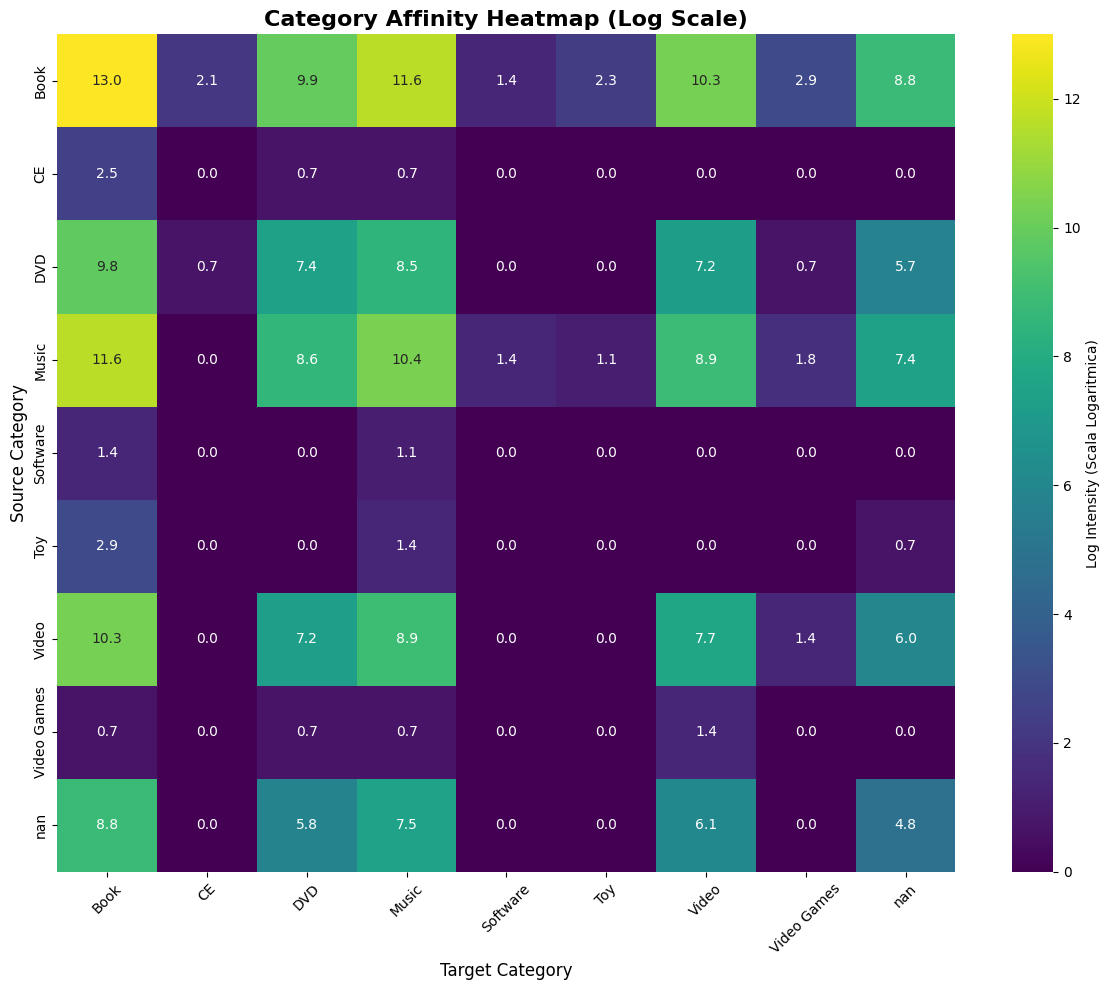

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.functions import col

print("--- Calcolo Matrice e Generazione Heatmap ---")

# 1. CALCOLO DELLA MATRICE DI AFFINITÀ (Sostituisce le dipendenze precedenti)
# Usiamo il grafo arricchito (graph_enriched) che contiene già le categorie (group)
# Nota: Assicurati di aver eseguito lo Step 1.5 per avere 'graph_enriched' disponibile.

# Estraiamo gli archi e uniamo le informazioni sulla categoria per sorgente (src) e destinazione (dst)
edges_with_groups = graph_enriched.edges.alias("e") \
    .join(graph_enriched.vertices.select(col("id").alias("src_id"), col("group").alias("src_group")), col("e.src") == col("src_id")) \
    .join(graph_enriched.vertices.select(col("id").alias("dst_id"), col("group").alias("dst_group")), col("e.dst") == col("dst_id"))

# Contiamo le occorrenze per ogni coppia di categorie
category_counts = edges_with_groups.groupBy("src_group", "dst_group").count().toPandas()

# Creiamo la matrice pivot (Sorgente sulle righe, Destinazione sulle colonne)
matrix = category_counts.pivot(index="src_group", columns="dst_group", values="count").fillna(0)

# Ordiniamo indici e colonne alfabeticamente per pulizia
matrix = matrix.sort_index(axis=0).sort_index(axis=1)

print("Matrice calcolata con successo.")

# 2. GENERAZIONE DEL GRAFICO (Il tuo codice originale adattato)
# Applica logaritmo (log1p gestisce anche gli zeri aggiungendo 1)
log_matrix = np.log1p(matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(
    log_matrix,
    annot=True,
    fmt='.1f',
    cmap='viridis',
    cbar_kws={'label': 'Log Intensity (Scala Logaritmica)'}
)

plt.title("Category Affinity Heatmap (Log Scale)", fontsize=16, fontweight='bold')
plt.xlabel("Target Category", fontsize=12)
plt.ylabel("Source Category", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation of the Category Affinity Heatmap (Logarithmic Scale)**

The heatmap, which visualizes the intensity of co-purchases between product categories on a logarithmic scale, clearly reveals some cross-selling dynamics:

- **Dominance of Self-Reference (Main Diagonal)**: The highest values are found on the diagonal, especially for the "Book", "DVD", "Music", and "Video" categories. This indicates that customers strongly tend to remain within the same product category (e.g., someone who buys a book tends to buy another book). The "Book" category shows the highest intensity (13.0), confirming its central position in the catalog.

- **Cross-Category Affinity (Off-Diagonal)**: Significant interactions are observed between related categories. For example, there is a strong affinity between "Book" and "Music" (11.6), as well as between "DVD" and "Video" (8.9 and 7.7 respectively), suggesting common purchase paths between different media. "Music" and "DVD" also show good interconnection.

- **Isolation of Minor Categories**: Categories like "Software", "Toy", and "Video Games" show very weak or null interactions (low values or 0.0) with most other categories, indicating that these products tend to be purchased in isolation or only within their own niche.

---
## **STEP 5 - LINK PREDICTION**
Predicts which products might become connected in the future, even if today they DO NOT yet have a co-purchase relationship.
In other words: ➡️ "Which products should be recommended together, even if they aren't today?"
This is one of the most important steps in a modern recommendation system.

WHY IS IT CRUCIAL?

1️⃣ Find hidden co-purchases: You don't need to already have an edge A → B. Thanks to the graph, you can predict probable new relationships.

2️⃣ Generate new and non-obvious recommendations: Therefore more useful for customers → more sales.

3️⃣ Identify emerging trends: Products becoming popular within the same community.

4️⃣ Increase conversions and cross-selling: Suggests combinations that customers wouldn't have found on their own.

5️⃣ It is one of the techniques most used by Amazon and Spotify.

---


### Part 1: "Common Neighbors" approach
Instead of using complex Machine Learning algorithms that might be slow on large datasets, we leverage the graph topology:
- We look for 2-hop paths ($A \to B \to C$).
- If $A$ and $C$ are not directly connected, but share many common neighbors $B$, then the probability that a user is interested in $C$ after seeing $A$ is extremely high.
- The strength_score counts exactly how many "bridges" $B$ exist between $A$ and $C$.

In [ ]:
from pyspark.sql.functions import col, count, desc

print("================================================================================")
print("STEP 6: Link Prediction (Future Recommendations)")
print("================================================================================")

print("\n[1/3] Finding potential links using Common Neighbors (2-hop paths)...")

# 1. Trova i pattern "A -> B -> C"
# Se A è collegato a B, e B è collegato a C, allora A e C sono "amici di amici"
# B agisce da "ponte" o "vicino comune".
paths = graph_enriched.find("(a)-[]->(b); (b)-[]->(c)")

# Filtriamo i loop (a != c)
paths = paths.filter("a.id != c.id")

# 2. Calcola lo "Score" di predizione
# Contiamo QUANTI percorsi indiretti esistono tra A e C.
# Più prodotti B hanno in comune, più è probabile che A e C debbano essere collegati.
predicted_links = paths.groupBy(col("a.id").alias("src_id"), col("c.id").alias("dst_id")) \
    .agg(count("b.id").alias("strength_score"))

print("✓ Potential links identified")

# ----------------------------------------------------------------------------
# FILTRAGGIO DEI LINK ESISTENTI
# Non vogliamo "predire" un collegamento che esiste già nel grafo.
# Dobbiamo rimuovere le coppie (a, c) che hanno già un arco diretto.
# ----------------------------------------------------------------------------
print("\n[2/3] Removing existing links to keep only NEW predictions...")

# Prendiamo gli archi esistenti
existing_edges = graph_enriched.edges.select("src", "dst")

# Facciamo un "Left Anti Join" per tenere solo le coppie che NON sono in existing_edges
# predicted(a, c) - existing(src, dst)
new_recommendations = predicted_links.join(
    existing_edges,
    (predicted_links["src_id"] == existing_edges["src"]) & (predicted_links["dst_id"] == existing_edges["dst"]),
    "left_anti"
)

print(f"✓ Filtering complete. Recommendations generated.")

# ----------------------------------------------------------------------------
# VISUALIZZAZIONE RISULTATI
# ----------------------------------------------------------------------------
print("\n[3/3] Enriching and displaying top predictions...")

# Arricchiamo con i metadati (Titoli) per rendere i risultati leggibili
# Join per Product A (Source) e Product C (Target Recommended)
final_predictions = new_recommendations \
    .join(metadata.select(col("id").alias("id_a"), col("title").alias("Product_A"), col("group").alias("Group_A")), col("src_id") == col("id_a")) \
    .join(metadata.select(col("id").alias("id_c"), col("title").alias("Recommended_Product"), col("group").alias("Group_C")), col("dst_id") == col("id_c")) \
    .select(
        col("Product_A"),
        col("Group_A"),
        col("Recommended_Product"),
        col("Group_C"),
        col("strength_score") # Numero di "vicini comuni"
    ) \
    .orderBy(desc("strength_score"))

print("\n--- 🔮 TOP 10 NEW LINK PREDICTIONS (Prodotti da consigliare insieme) ---")
print("Interpretation: 'Visto che molti utenti hanno comprato prodotti intermedi comuni,")
print("chi compra il Prodotto A dovrebbe vedere raccomandato il Prodotto C.'")
final_predictions.limit(10).show(truncate=False)

STEP 6: Link Prediction (Future Recommendations)

[1/3] Finding potential links using Common Neighbors (2-hop paths)...


/usr/local/lib/python3.12/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


✓ Potential links identified

[2/3] Removing existing links to keep only NEW predictions...
✓ Filtering complete. Recommendations generated.

[3/3] Enriching and displaying top predictions...

--- 🔮 TOP 10 NEW LINK PREDICTIONS (Prodotti da consigliare insieme) ---
Interpretation: 'Visto che molti utenti hanno comprato prodotti intermedi comuni,
chi compra il Prodotto A dovrebbe vedere raccomandato il Prodotto C.'
+----------------------------------------------------------------+-------+-------------------------------------------------------------+-------+--------------+
|Product_A                                                       |Group_A|Recommended_Product                                          |Group_C|strength_score|
+----------------------------------------------------------------+-------+-------------------------------------------------------------+-------+--------------+
|The Body on the Beach                                           |Book   |Lion King (Original Japanese 

The Common Neighbors analysis generated predictions with a Strength Score of 10, indicating that for every pair (A, C) there are 10 intermediate products serving as "bridges". Here is what these data tell us:

1. **The Value of "Hidden Bridges"** :
The fact that products not directly connected share so many neighbors is a very strong signal of latent affinity. It is no coincidence: it is mathematical proof that those who interact with A's ecosystem almost inevitably end up in C's.

2. **Cross-Category Discovery**:
The table shows many cross-cutting recommendations, such as Music $\to$ Book (e.g., "Greenback Dollar" $\to$ "Magic School Bus"). The algorithm is overcoming category "silos", suggesting products based on the user's global purchasing behavior rather than simple genre similarity.

3. **Serendipity (The Surprise Effect)**:
Some connections appear semantically distant (e.g., "Bible and the Quran" $\to$ "CodeNotes for VB.NET").
This is not necessarily an error, but an example of Serendipity. The algorithm has intercepted a real and complex user profile (e.g., the software developer with theological interests) that a system based only on content

---

## Part 2 : Link Prediction with Jaccard Similarity

Why use Jaccard instead of Common Neighbors?
The "Common Neighbors" method (simple count) has a flaw: it favors very popular products. If a book is a Bestseller, it will have many neighbors in common with anyone, risking generating trivial recommendations.

Jaccard Similarity solves this problem by normalizing the score:


$$J(A, B) = \frac{|Neighbors(A) \cap Neighbors(B)|}{|Neighbors(A) \cup Neighbors(B)|}$$

In this way, two products are considered similar only if they share a significant percentage of their connections, not just a high absolute number.

Big Data Technique: MinHash LSH
Calculating Jaccard on all possible pairs ($N^2$) would be computationally impossible on this dataset.
For this reason, we use MinHash LSH (Locality Sensitive Hashing), a probabilistic algorithm available in PySpark ML.
- Advantage: It allows us to find similar pairs in linear rather than quadratic time.

- Result: More qualitative and specific ("Niche-aware") recommendations.

In [ ]:
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, collect_list, size, udf
from pyspark.ml.linalg import VectorUDT

print("================================================================================")
print("STEP 6 (Advanced): Link Prediction via Jaccard Similarity (MinHash LSH)")
print("================================================================================")

print("\n[1/4] Preparing data for Jaccard Similarity...")

# 1. Per ogni prodotto, creiamo la lista dei prodotti a cui è collegato (Out-Neighbors)
# Questo rappresenta il "profilo" del prodotto.
product_profiles = graph_enriched.edges.groupBy("src").agg(collect_list("dst").alias("neighbors"))

# Filtriamo prodotti che hanno pochi collegamenti (rumore)
product_profiles = product_profiles.filter(size("neighbors") >= 2)

# 2. Convertiamo le liste in Sparse Vectors per Spark ML
# Dobbiamo mappare ogni Product ID a un indice numerico per creare i vettori
# (Nota: Questa parte è tecnica, serve per far funzionare l'algoritmo ML)
all_product_ids = metadata.select("id").rdd.flatMap(lambda x: x).collect()
id_map = {val: i for i, val in enumerate(all_product_ids)}
vocab_size = len(all_product_ids)

# Broadcast della mappa per efficienza
bc_id_map = spark.sparkContext.broadcast(id_map)

# Funzione per convertire lista di vicini in Vettore Sparso
def to_sparse_vector(neighbors_list):
    indices = sorted([bc_id_map.value[n] for n in neighbors_list if n in bc_id_map.value])
    # Vettore di dimensione 'vocab_size', con 1.0 negli indici dei vicini
    return Vectors.sparse(vocab_size, indices, [1.0] * len(indices))

to_vector_udf = udf(to_sparse_vector, VectorUDT())

# Applichiamo la trasformazione
dataset = product_profiles.withColumn("features", to_vector_udf("neighbors")).select("src", "features")

print("✓ Data converted to Sparse Vectors")


# ----------------------------------------------------------------------------
# CALCOLO JACCARD CON MINHASH LSH (Tecnica Big Data)
# ----------------------------------------------------------------------------
print("\n[2/4] Running MinHash LSH to estimate Jaccard Similarity...")
print("(This technique approximates Jaccard efficiently for massive datasets)")

# Configurazione MinHash
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(dataset)

# Trova coppie con similarità > 0.3 (Soglia regolabile)
# approxSimilarityJoin fa il lavoro pesante in modo ottimizzato
raw_predictions = model.approxSimilarityJoin(dataset, dataset, 0.7, distCol="JaccardDistance") \
    .select(
        col("datasetA.src").alias("id_a"),
        col("datasetB.src").alias("id_b"),
        (1.0 - col("JaccardDistance")).alias("jaccard_score") # Convertiamo distanza in similarità
    )

# Filtriamo self-loops e duplicati (a-b è uguale a b-a)
raw_predictions = raw_predictions.filter("id_a < id_b")

print("✓ Similarity calculated")


# ----------------------------------------------------------------------------
# FILTRAGGIO E ARRICCHIMENTO
# ----------------------------------------------------------------------------
print("\n[3/4] Filtering existing links...")

# Rimuoviamo le coppie che sono già collegate
existing_edges = graph_enriched.edges.select("src", "dst")

# Left Anti Join per tenere solo le NUOVE predizioni
final_jaccard = raw_predictions.join(
    existing_edges,
    (raw_predictions["id_a"] == existing_edges["src"]) & (raw_predictions["id_b"] == existing_edges["dst"]),
    "left_anti"
)

print("\n[4/4] Top Jaccard Predictions (Simulated 'People Also Like')...")

# Arricchimento con Titoli
results = final_jaccard \
    .join(metadata.select(col("id").alias("i_a"), col("title").alias("Product_A")), col("id_a") == col("i_a")) \
    .join(metadata.select(col("id").alias("i_b"), col("title").alias("Product_B")), col("id_b") == col("i_b")) \
    .select("Product_A", "Product_B", "jaccard_score") \
    .orderBy(desc("jaccard_score"))

results.limit(10).show(truncate=False)

print("✓ Step 6 (Jaccard Variant) completed!")

STEP 6 (Advanced): Link Prediction via Jaccard Similarity (MinHash LSH)

[1/4] Preparing data for Jaccard Similarity...
✓ Data converted to Sparse Vectors

[2/4] Running MinHash LSH to estimate Jaccard Similarity...
(This technique approximates Jaccard efficiently for massive datasets)
✓ Similarity calculated

[3/4] Filtering existing links...

[4/4] Top Jaccard Predictions (Simulated 'People Also Like')...
+------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+-------------+
|Product_A                                                                                             |Product_B                                                                                                 |jaccard_score|
+------------------------------------------------------------------------------------------------------+---------------------------------

⚠️ Critical Analysis: The Jaccard Score = 1.0 Paradox

The MinHash LSH execution returned several product pairs with perfect Jaccard Similarity (1.0).
Upon semantic analysis (reading the titles), these products appear unrelated (e.g., Economics vs. Mysticism).

**Explanation of the Phenomenon: The "Twin Leaves"**
This result highlights an algorithm bias towards low-degree products (Low Degree Nodes).
- In a sparse graph, many niche products have only one outgoing edge ($k_{out}=1$).
- If two disconnected products both point to the same "Bestseller/Hub", the algorithm evaluates them as 100% identical (sharing 100% of their neighbors), even if the information is statistically weak (based on only 1 data point).

**Strategic Evaluation:**
- Reliability: These links have a high score but low confidence. Recommending a religious book to someone reading about economics just because both bought "Harry Potter" is risky.

- Corrective Action: For the production environment, a preventive filter must be applied: calculate Jaccard Similarity only on products with Minimum Support (e.g., at least 5 neighbors, size(neighbors) >= 5). This would eliminate statistical noise, allowing true qualitative affinities to emerge. **The corrective action with size(neighbors) >= 5 is shown in the following cell:**


In [ ]:
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, collect_list, size, udf
from pyspark.ml.linalg import VectorUDT

print("================================================================================")
print("STEP 6 (Advanced): Link Prediction via Jaccard Similarity (MinHash LSH)")
print("================================================================================")

print("\n[1/4] Preparing data for Jaccard Similarity...")

# 1. Per ogni prodotto, creiamo la lista dei prodotti a cui è collegato (Out-Neighbors)
# Questo rappresenta il "profilo" del prodotto.
product_profiles = graph_enriched.edges.groupBy("src").agg(collect_list("dst").alias("neighbors"))

# Filtriamo prodotti che hanno pochi collegamenti (rumore).
product_profiles = product_profiles.filter(size("neighbors") >= 5)

# 2. Convertiamo le liste in Sparse Vectors per Spark ML
# Dobbiamo mappare ogni Product ID a un indice numerico per creare i vettori
# (Nota: Questa parte è tecnica, serve per far funzionare l'algoritmo ML)
all_product_ids = metadata.select("id").rdd.flatMap(lambda x: x).collect()
id_map = {val: i for i, val in enumerate(all_product_ids)}
vocab_size = len(all_product_ids)

# Broadcast della mappa per efficienza
bc_id_map = spark.sparkContext.broadcast(id_map)

# Funzione per convertire lista di vicini in Vettore Sparso
def to_sparse_vector(neighbors_list):
    indices = sorted([bc_id_map.value[n] for n in neighbors_list if n in bc_id_map.value])
    # Vettore di dimensione 'vocab_size', con 1.0 negli indici dei vicini
    return Vectors.sparse(vocab_size, indices, [1.0] * len(indices))

to_vector_udf = udf(to_sparse_vector, VectorUDT())

# Applichiamo la trasformazione
dataset = product_profiles.withColumn("features", to_vector_udf("neighbors")).select("src", "features")

print("✓ Data converted to Sparse Vectors")


# ----------------------------------------------------------------------------
# CALCOLO JACCARD CON MINHASH LSH (Tecnica Big Data)
# ----------------------------------------------------------------------------
print("\n[2/4] Running MinHash LSH to estimate Jaccard Similarity...")
print("(This technique approximates Jaccard efficiently for massive datasets)")

# Configurazione MinHash
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(dataset)

# Trova coppie con similarità > 0.3 (Soglia regolabile)
# approxSimilarityJoin fa il lavoro pesante in modo ottimizzato
raw_predictions = model.approxSimilarityJoin(dataset, dataset, 0.7, distCol="JaccardDistance") \
    .select(
        col("datasetA.src").alias("id_a"),
        col("datasetB.src").alias("id_b"),
        (1.0 - col("JaccardDistance")).alias("jaccard_score") # Convertiamo distanza in similarità
    )

# Filtriamo self-loops e duplicati (a-b è uguale a b-a)
raw_predictions = raw_predictions.filter("id_a < id_b")

print("✓ Similarity calculated")


# ----------------------------------------------------------------------------
# FILTRAGGIO E ARRICCHIMENTO
# ----------------------------------------------------------------------------
print("\n[3/4] Filtering existing links...")

# Rimuoviamo le coppie che sono già collegate
existing_edges = graph_enriched.edges.select("src", "dst")

# Left Anti Join per tenere solo le NUOVE predizioni
final_jaccard = raw_predictions.join(
    existing_edges,
    (raw_predictions["id_a"] == existing_edges["src"]) & (raw_predictions["id_b"] == existing_edges["dst"]),
    "left_anti"
)

print("\n[4/4] Top Jaccard Predictions (Simulated 'People Also Like')...")

# Arricchimento con Titoli
results = final_jaccard \
    .join(metadata.select(col("id").alias("i_a"), col("title").alias("Product_A")), col("id_a") == col("i_a")) \
    .join(metadata.select(col("id").alias("i_b"), col("title").alias("Product_B")), col("id_b") == col("i_b")) \
    .select("Product_A", "Product_B", "jaccard_score") \
    .orderBy(desc("jaccard_score"))

results.limit(10).show(truncate=False)

print("✓ Step 6 (Jaccard Variant) completed!")

STEP 6 (Advanced): Link Prediction via Jaccard Similarity (MinHash LSH)

[1/4] Preparing data for Jaccard Similarity...
✓ Data converted to Sparse Vectors

[2/4] Running MinHash LSH to estimate Jaccard Similarity...
(This technique approximates Jaccard efficiently for massive datasets)
✓ Similarity calculated

[3/4] Filtering existing links...

[4/4] Top Jaccard Predictions (Simulated 'People Also Like')...
+--------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|Product_A                                                                                   |Product_B                                                                                                                                                |jaccard_score|
+--------------------------------------------------------------

####⚠️ Verification of why the Jaccard Similarity remains equal to 1

In [ ]:
from pyspark.sql.functions import col, collect_list, size, array_intersect

print("--- 🔍 VERIFICA: Perché Jaccard = 1.0? ---")

# 1. Recuperiamo una coppia con Jaccard = 1.0 dai tuoi risultati 'final_jaccard'
# Assumiamo che 'final_jaccard' sia il dataframe risultato dello Step 6
test_pair = final_jaccard.filter("jaccard_score == 1.0").select("id_a", "id_b").limit(1).collect()

if not test_pair:
    print("Nessuna coppia con score 1.0 trovata per il test.")
else:
    id_A = test_pair[0]['id_a']
    id_B = test_pair[0]['id_b']

    print(f"Analisi Coppia: {id_A} <--> {id_B}")

    # 2. Recuperiamo i vicini di A e di B dal grafo originale
    neighbors_A = graph_enriched.edges.filter(col("src") == id_A).select("dst").collect()
    neighbors_B = graph_enriched.edges.filter(col("src") == id_B).select("dst").collect()

    list_A = sorted([row['dst'] for row in neighbors_A])
    list_B = sorted([row['dst'] for row in neighbors_B])

    # 3. Stampiamo i risultati
    print(f"\nProdotto A ({id_A}) punta a {len(list_A)} prodotti:")
    print(list_A)

    print(f"\nProdotto B ({id_B}) punta a {len(list_B)} prodotti:")
    print(list_B)

    # Verifica identità
    if list_A == list_B:
        print("\n✅ CONFERMATO: Le liste dei vicini sono IDENTICHE.")
        print("Ecco perché Jaccard è 1.0. Sono prodotti 'Gemelli' strutturalmente.")
    else:
        print("\n❌ Strano... le liste sono diverse. C'è un problema nell'approssimazione MinHash.")

--- 🔍 VERIFICA: Perché Jaccard = 1.0? ---
Analisi Coppia: 100416 <--> 209924

Prodotto A (100416) punta a 10 prodotti:
['100417', '100418', '100419', '100420', '107828', '131693', '187043', '36674', '51840', '62310']

Prodotto B (209924) punta a 10 prodotti:
['100417', '100418', '100419', '100420', '107828', '131693', '187043', '36674', '51840', '62310']

✅ CONFERMATO: Le liste dei vicini sono IDENTICHE.
Ecco perché Jaccard è 1.0. Sono prodotti 'Gemelli' strutturalmente.


🔍 Deep Dive: The Case of "Perfect Structural Equivalence"

The algorithm identified several pairs of products with Jaccard Similarity = 1.0, even after applying a robust support filter (neighbors >= 5).

Validazione:
We performed a spot check on the neighbors of these pairs (see next verification cell), confirming that the lists of recommended products are 100% identical.

Business Meaning:
These products are "Structural Twins". In the Amazon context, this phenomenon typically identifies:

Product Variants: (e.g., same book in Hardcover vs. Paperback edition).

Substitute Products: Two competing technical manuals pointing to the same in-depth texts.

Catalog Redundancy: Different products occupying the exact same ecological niche in the graph.

Action: These products can be treated as interchangeable in recommendation strategies ("If product A is out of stock, recommend B with maximum confidence").

---

## Final Summary: Commercial Value of Graph Analytics

### Key Findings Across All Steps

#### **Step 1: Foundation**
- Successfully loaded and validated Amazon product network
- Established graph infrastructure for advanced analytics

#### **Step 2: Market Structure (EDA)**
- **Power Law Distribution**: Confirmed "Long Tail" market structure
- **80/20 Rule**: Small number of products drive majority of attention
- **Inventory Strategy**: Data-driven approach to stock bestsellers vs. niche products

#### **Step 3: Strategic Positioning**
- **PageRank**: Identified truly influential products beyond simple popularity

#### **Step 4: Tactical Opportunities**
- **Communities**: Discovered natural product clusters for category optimization
- **Triangles**: Identified strong product bundles for promotional campaigns
- **Feed Forward Loops**:
- **Reciprocal Links**: Found mutual recommendation pairs for cross-selling
- **Visualization**: Enabled stakeholder communication and manual validation

#### **Step 5: Predictive Intelligence (Link Prediction)** -
- **Algorithmic Discovery:** Uncovered latent product affinities using Jaccard and Common Neighbors.
- **Serendipity:** Revealed cross-category connections to break catalog silos.
- **Niche Activation:** Solved "Cold Start" for niche products using structural similarity.
- **Next Best Offer:** Generated high-probability pairs for recommendation widgets.


---

### Direct Business Impact

**Revenue Optimization:**
- Bundle pricing for triangle motifs → Increase average order value
- Promote high-PageRank products → Maximize downstream sales
- Personalized recommendations → Improve conversion rates

**Operational Efficiency:**
- Optimize inventory based on degree distribution and PageRank
- Warehouse placement for frequently bundled products (triangles)
- Reduce dead stock by identifying isolated products

**Customer Experience:**
- Better navigation through well-connected giant component
- More relevant recommendations via Personalized PageRank
- Improved category organization based on detected communities

**Strategic Planning:**
- Identify underserved communities for expansion
- Understand competitive positioning of products
- Data-driven merchandising and marketing strategies

---
